## Custom Modelling

In [1]:
import time

# Get notebook runtime
startTime = time.time()

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
# Read data from stored csv files
import pandas as pd
Final_Dataset_Provider_Train = pd.read_csv('../output/Final_Train.csv')
#Final_Dataset_Provider_Train = Final_Dataset_Provider_Train.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
#Modifications to original file by JAF
Final_Dataset_Provider_Train = Final_Dataset_Provider_Train.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], axis=1, errors='ignore')
Final_Dataset_Provider_Test = pd.read_csv('../output/Final_Test.csv')
#Final_Dataset_Provider_Test = Final_Dataset_Provider_Test.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
#Modifications to original file by JAF
Final_Dataset_Provider_Test = Final_Dataset_Provider_Test.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], axis=1, errors='ignore')

1) Split your whole data into train and test(80-20)



2) Now, in the 80% train set, split the train set into D1 and D2.(50-50).



From this D1, do sampling with replacement to create d1,d2,d3....dk(k samples).



Now create 'k' models and train each of these models with each of these k samples.



3) Now pass the D2 set to each of these k models; now, you will get k predictions for D2 from each of these models.



4) Now, using these k predictions, create a new dataset, and for D2, you already know it's corresponding target values, so now you train a metamodel with these k predictions.



5) Now, for model evaluation, you have can use the 20% data that you have kept as the test set. Pass that test set to each of the base models, and you will get 'k' predictions. Now you create a new dataset with these k predictions and pass it to your metamodel, and you will get the final prediction. Using this final prediction and the targets for the test set, you can calculate the model's performance score.



I hope you got it. For base models, you can consider any Tree-based model; you can take the Decision Tree itself. And here, you can tune for the number of base models. The procedure mentioned above requires you to do custom coding. There are no library functions available for this as it is a custom model implementation.

In [4]:
Final_Dataset_Provider_Train.head(2)

Provider  PotentialFraud  InscClaimAmtReimbursed  DeductibleAmtPaid  \
0  PRV51001               0                  104640             5340.0   
1  PRV51003               1                  605670            66286.0   

   Hospitalization_Duration  Claim_Period  ExtraClaimDays  \
0                      30.0            61             0.0   
1                     382.0           617             0.0   

   Inpatient_or_Outpatient  RenalDiseaseIndicator  NoOfMonths_PartACov  ...  \
0                        5                      8                  300  ...   
1                       62                     29                 1560  ...   

   PerProviderClmDiagnosisCode_4_count_ClaimID  \
0                                          297   
1                                         3046   

   PerProviderClmDiagnosisCode_5_count_ClaimID  \
0                                          297   
1                                         4452   

   PerProviderClmDiagnosisCode_6_count_ClaimID  \
0                                          297   
1                                         5556   

   PerProviderDiagnosisGroupCode_count_ClaimID  Gender_0  Gender_1  Race_1  \
0                                          405      16.0       9.0    21.0   
1                                         4972      78.0      54.0   107.0   

   Race_2  Race_3  Race_5  
0     4.0     0.0     0.0  
1    24.0     0.0     1.0  

[2 rows x 247 columns]

In [5]:
Final_Dataset_Provider_Train.shape, Final_Dataset_Provider_Test.shape

((5410, 247), (1353, 246))

#### Split your whole data into train and test(80-20)

In [6]:
# Split your whole data into train and test(80-20)
from sklearn.model_selection import train_test_split
Final_Dataset_Provider_Tr, Final_Dataset_Provider_val = train_test_split(Final_Dataset_Provider_Train, test_size=0.2,
                               random_state=42,stratify=Final_Dataset_Provider_Train['PotentialFraud'])
Final_Dataset_Provider_Tr.shape, Final_Dataset_Provider_val.shape

((4328, 247), (1082, 247))

In [7]:
# Seperate dependent and independent variables
x_train = Final_Dataset_Provider_Tr.drop(axis=1,columns=['Provider','PotentialFraud'])
y_train = Final_Dataset_Provider_Tr['PotentialFraud']
x_train.shape, y_train.shape

((4328, 245), (4328,))

In [8]:
# prepare test data
x_test = Final_Dataset_Provider_Test.drop(axis=1,columns=['Provider'])

In [9]:
# Seperate dependent and independent variables
x_validation_provider_labels = Final_Dataset_Provider_val[['Provider','PotentialFraud']]
x_validation = Final_Dataset_Provider_val.drop(columns=['Provider','PotentialFraud'],axis=1)
y_validation = Final_Dataset_Provider_val['PotentialFraud']
x_validation.shape, y_validation.shape

((1082, 245), (1082,))

In [10]:
from sklearn.preprocessing import StandardScaler
# Standardize the data (train and test)
standard_scaler = StandardScaler()
standard_scaler.fit(x_train)
x_tr = standard_scaler.transform(x_train)
x_val = standard_scaler.transform(x_validation)
x_test_std = standard_scaler.transform(x_test)

# convert pandas.core.series.Series to numpy.ndarray
y_tr = y_train.to_numpy()
y_val = y_validation.to_numpy()

In [11]:
x_val.shape, y_val.shape

((1082, 245), (1082,))

#### Now, in the 80% train set, split the train set into D1 and D2.(50-50)

In [12]:
# Now, in the 80% train set, split the train set into D1 and D2.(50-50)
x_d1, x_d2, y_d1, y_d2 = train_test_split(x_tr, y_tr, test_size=0.5,random_state=42,stratify=y_tr)
x_d1.shape, x_d2.shape, y_d1.shape, y_d2.shape

((2164, 245), (2164, 245), (2164,), (2164,))

In [13]:
from sklearn.metrics import roc_curve, auc , f1_score
import matplotlib.pyplot as plt
def pred_prob(clf, data):
    # predicts the probabability of class label using the model
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc))
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)", size = 14)
    plt.ylabel("True Positive Rate(TPR)", size = 14)
    plt.title("Area Under Curve", size = 16)
    plt.grid(b=True, which='major', color='g', linestyle='-')
    plt.show()
    
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
#     print("max(tpr*(1-fpr)) = ", max(tpr*(1-fpr)), "for threshold = ", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [14]:
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    # Confusion matrix for train and test dataset
    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Train Dataset Confusion Matrix', size = 16)
    ax[0].set_xlabel("Predicted Label", size = 14)
    ax[0].set_ylabel("Actual Label", size = 14)

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[1])
    ax[1].set_title('Test Dataset Confusion Matrix', size = 16)
    ax[1].set_xlabel("Predicted Label", size = 14)
    ax[1].set_ylabel("Actual Label", size = 14)
    # plt.grid()
    plt.show()
    
    return train_prediction, test_prediction

In [15]:
def validate_model(clf, x_train, x_test, y_train, y_test):
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    # calculate tpr, fpr for diffeent thresholds using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("Train AUC = ", train_auc)
    test_auc = auc(test_fpr, test_tpr)
    print("Test AUC = ", test_auc)
    
    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)
    
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
    
    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    
    return test_auc, test_f1_score, best_t

#### Define a function to randomly sample data from dataset

In [16]:
# define a function to randomly sample data from dataset
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
import numpy as np
def row_col_sampling(x, y):
    total_row_count = x.shape[0]
    total_col_count = x.shape[1]
    # in sampled data i want to keep minimum 40% to maximum 60% number of rows
    sampled_row_count_min = round(total_row_count * 0.4)
    sampled_row_count_max = round(total_row_count * 0.6)
    # in a single dataset the rows should be unique, so setting "replace=False"
    sampled_row_indices = np.random.choice(total_row_count, np.random.randint(sampled_row_count_min,
                                                                              sampled_row_count_max),replace=False)
    sampled_row_indices = np.sort(sampled_row_indices)
    
    sampled_col_count_min = round(total_col_count * 0.4)
    sampled_col_count_max = round(total_col_count * 0.6)
    sampled_col_indices = np.random.choice(total_col_count, np.random.randint(sampled_col_count_min,
                                                                              sampled_col_count_max),replace=False)
    sampled_col_indices = np.sort(sampled_col_indices)
    # now select the sampled rows and columns from the input data
    
    #print(len(sampled_row_indices), len(sampled_col_indices))
    x_sampled = x[sampled_row_indices[:,None], sampled_col_indices]
    y_sampled = y[sampled_row_indices]
    #print(x_sampled.shape)
    
    return x_sampled, y_sampled, sampled_row_indices, sampled_col_indices

#### Function to create k sampled dataset

In [17]:
def create_k_dataset(x_tr, x_te, y_tr, y_te, k):
    x_tr_list = []
    y_tr_list = []
    x_te_list = []
    # y_te_list = []
    sampled_col_indices_list = []
    for i in range(k):
        x_sampled, y_sampled, sampled_row_indices, sampled_col_indices = row_col_sampling(x_tr, y_tr)
        x_tr_list.append(x_sampled)
        y_tr_list.append(y_sampled)
        x_te_list.append(x_te[:,sampled_col_indices])
        # y_te_list.append(y_te)
        sampled_col_indices_list.append(sampled_col_indices)
    return x_tr_list, y_tr_list, x_te_list, y_te, sampled_col_indices_list

#### Function to train k sampled dataset using decision tree, then create data for meta model

## Base Learner - DecisionTreeClassifier

In [18]:
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    model_list = []
    for i in range(k):
        base_learner = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 50, min_samples_split = 100)
        base_learner = base_learner.fit(x_tr_list[i], y_tr_list[i])
        model_list.append(base_learner)
    
    base_model_prediction_list = []
    for j in range(k):
        #y_pred = model_list[j].predict(x_te_list[j])
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)
    
    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()
    # print(x_tr_from_base_learner.shape)
    
    return x_tr_meta_model, model_list

						Number of base learners =  10
Train AUC =  0.9362819309453881
Test AUC =  0.9510905218962263


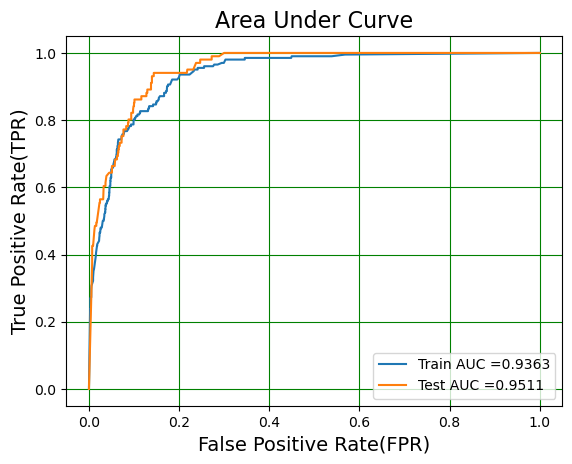

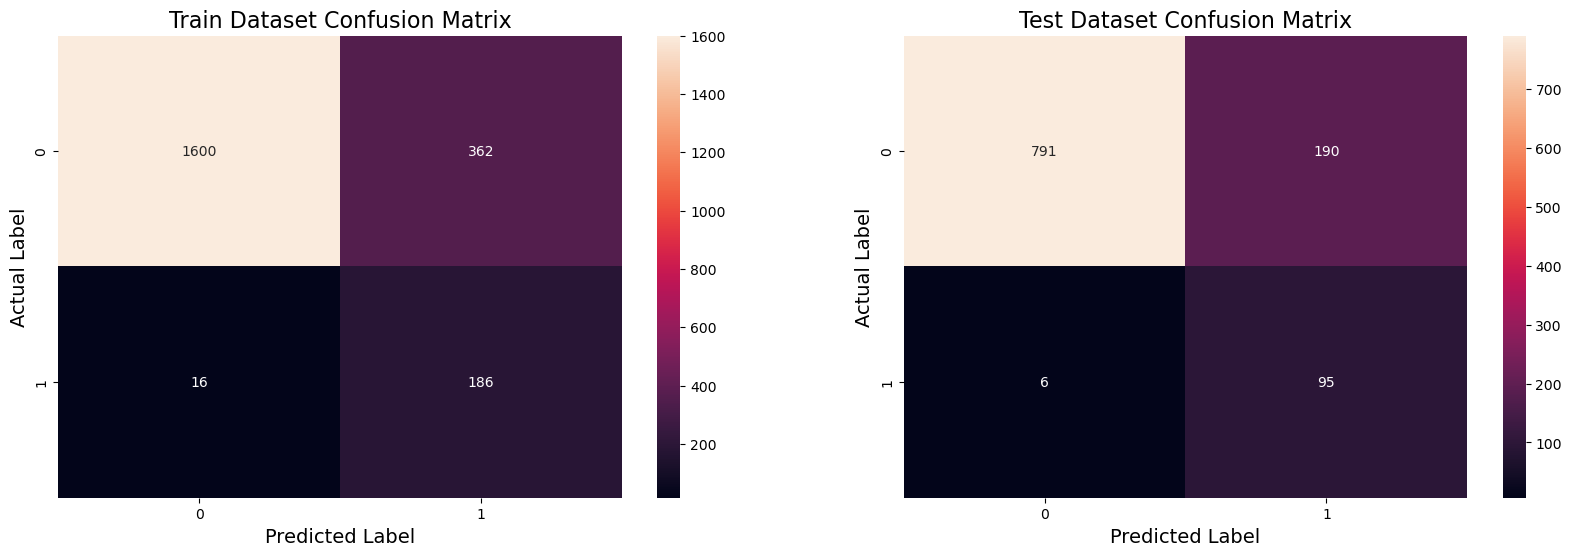

Best Threshold = 0.1007
Model AUC is : 0.9511
Model F1 Score is : 0.4922
						Number of base learners =  20
Train AUC =  0.9389716494585238
Test AUC =  0.9487288178359121


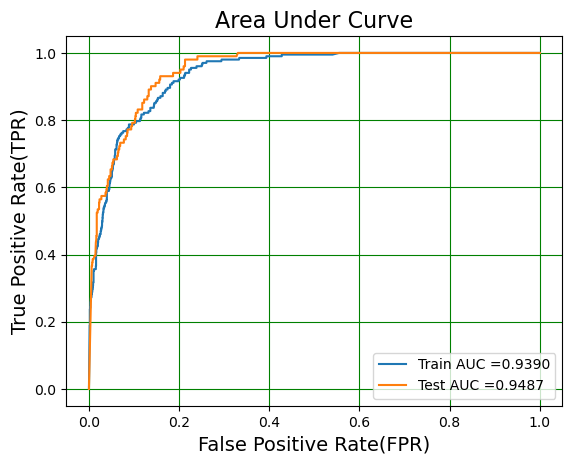

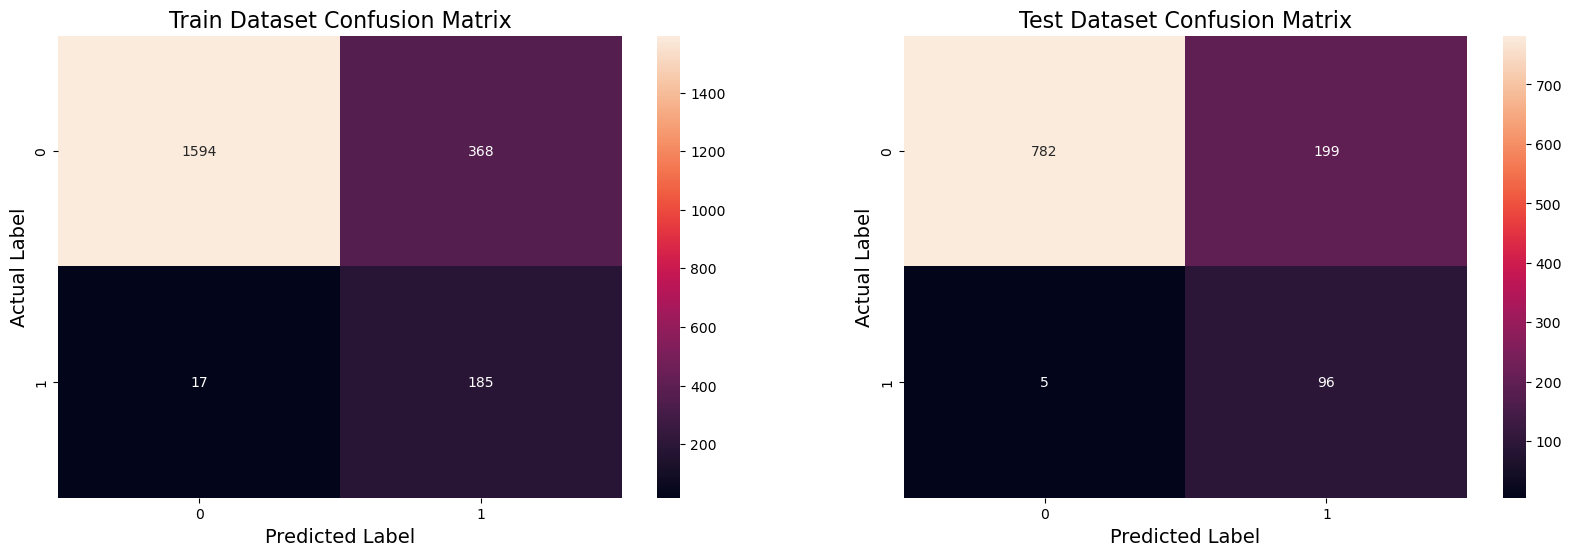

Best Threshold = 0.0997
Model AUC is : 0.9487
Model F1 Score is : 0.4848
						Number of base learners =  50
Train AUC =  0.9399052290550156
Test AUC =  0.951963544978351


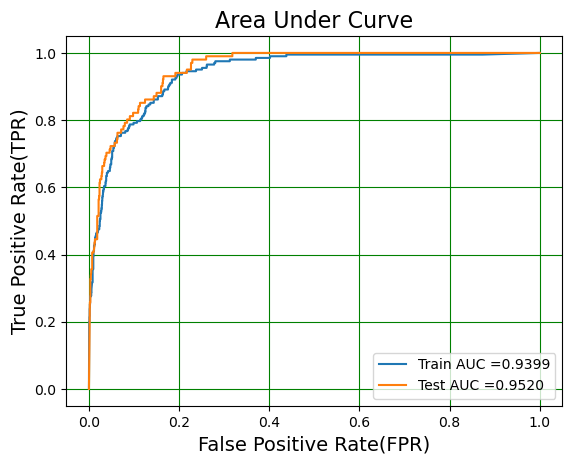

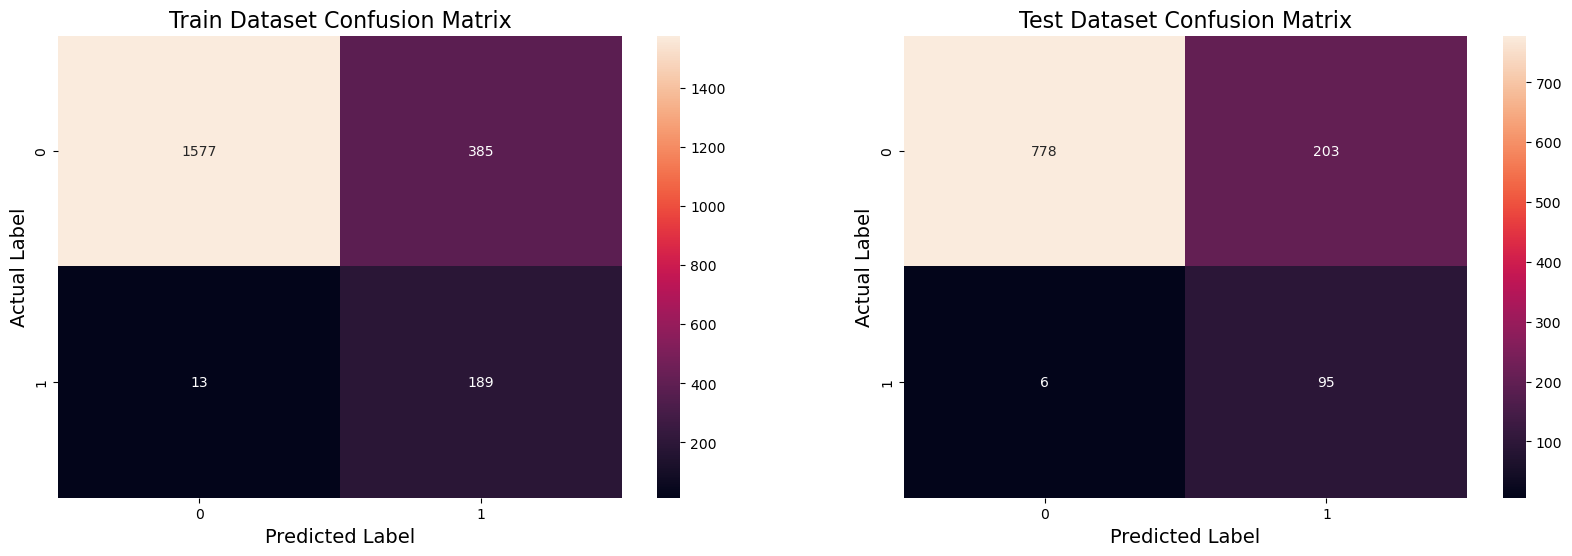

Best Threshold = 0.0853
Model AUC is : 0.9520
Model F1 Score is : 0.4762
						Number of base learners =  80
Train AUC =  0.9406647086727022
Test AUC =  0.9510350117580566


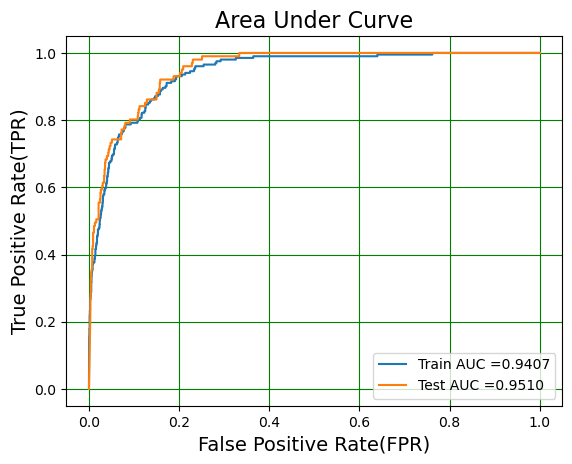

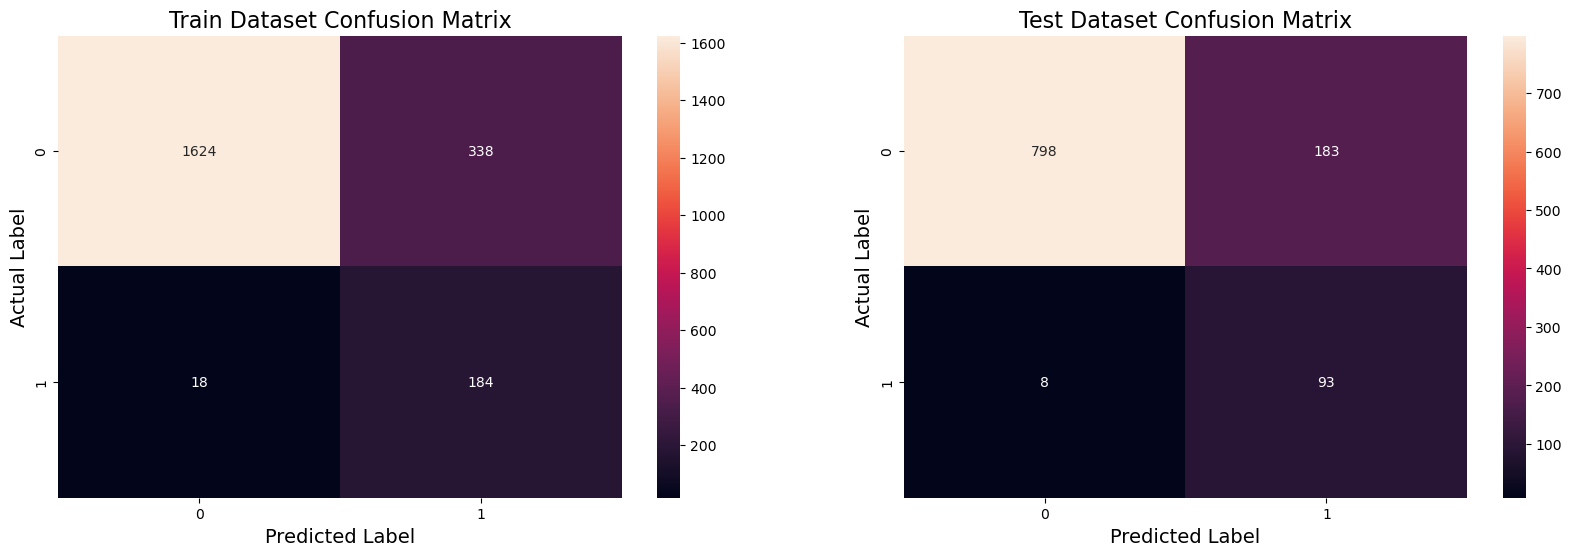

Best Threshold = 0.0929
Model AUC is : 0.9510
Model F1 Score is : 0.4934
						Number of base learners =  100
Train AUC =  0.9401625942410755
Test AUC =  0.9530888868703384


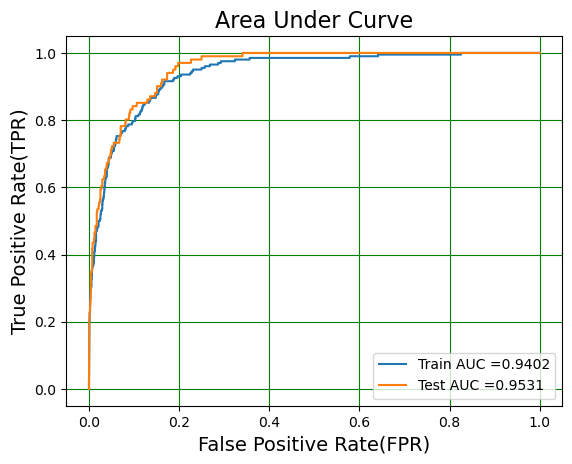

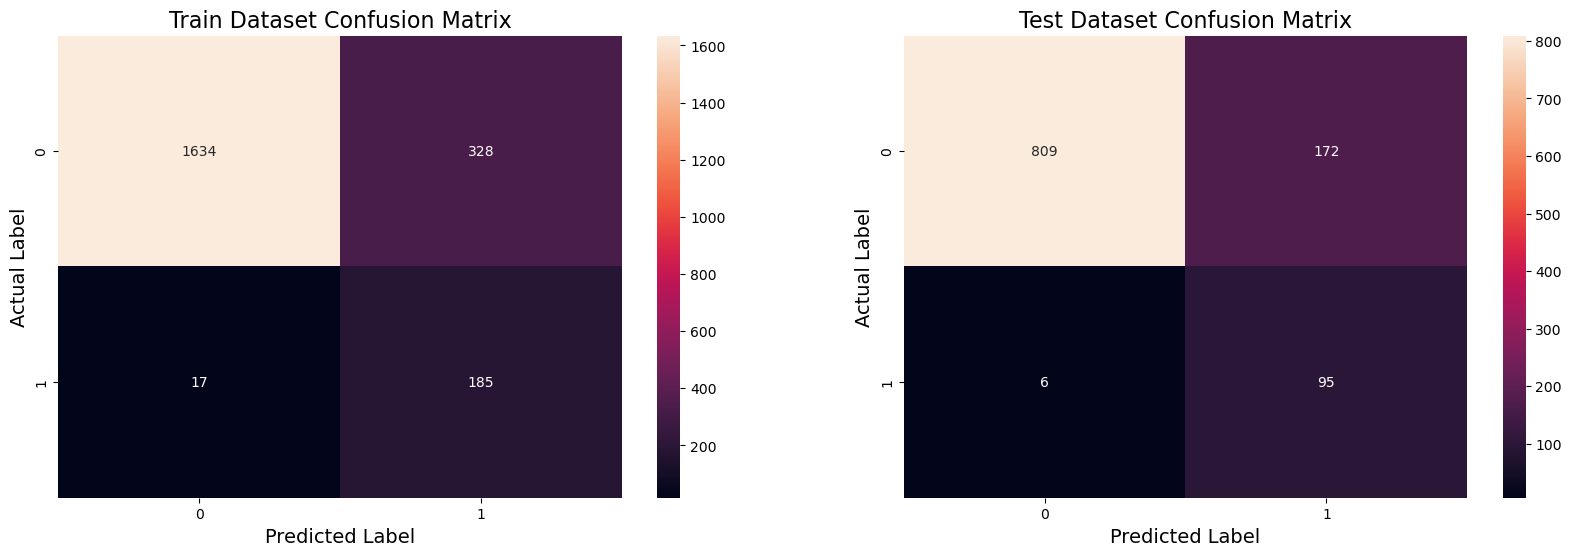

Best Threshold = 0.0915
Model AUC is : 0.9531
Model F1 Score is : 0.5163
						Number of base learners =  150
Train AUC =  0.9421218497996589
Test AUC =  0.9530434694845631


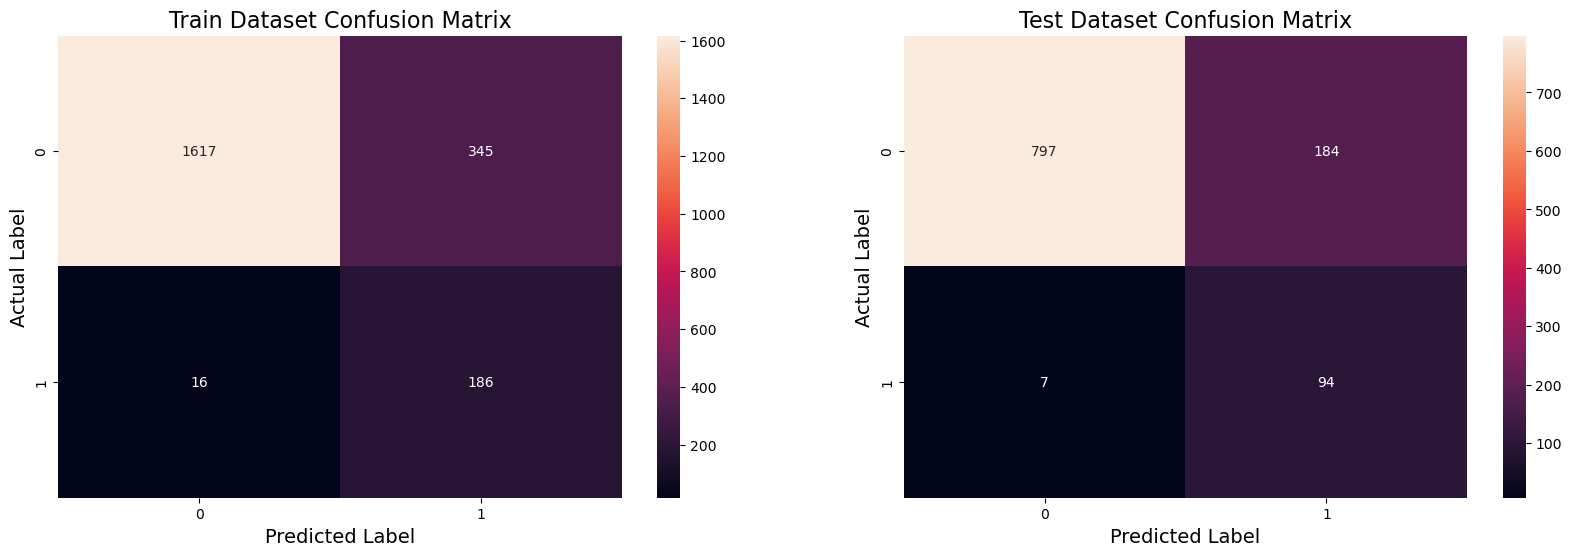

Best Threshold = 0.0790
Model AUC is : 0.9530
Model F1 Score is : 0.4960
						Number of base learners =  175
Train AUC =  0.9413901252510573
Test AUC =  0.9527356405365308


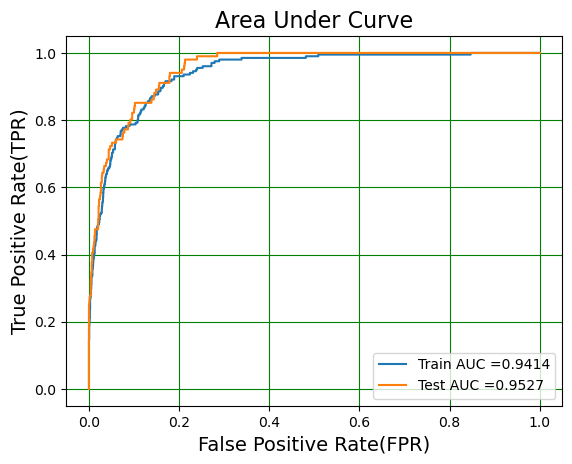

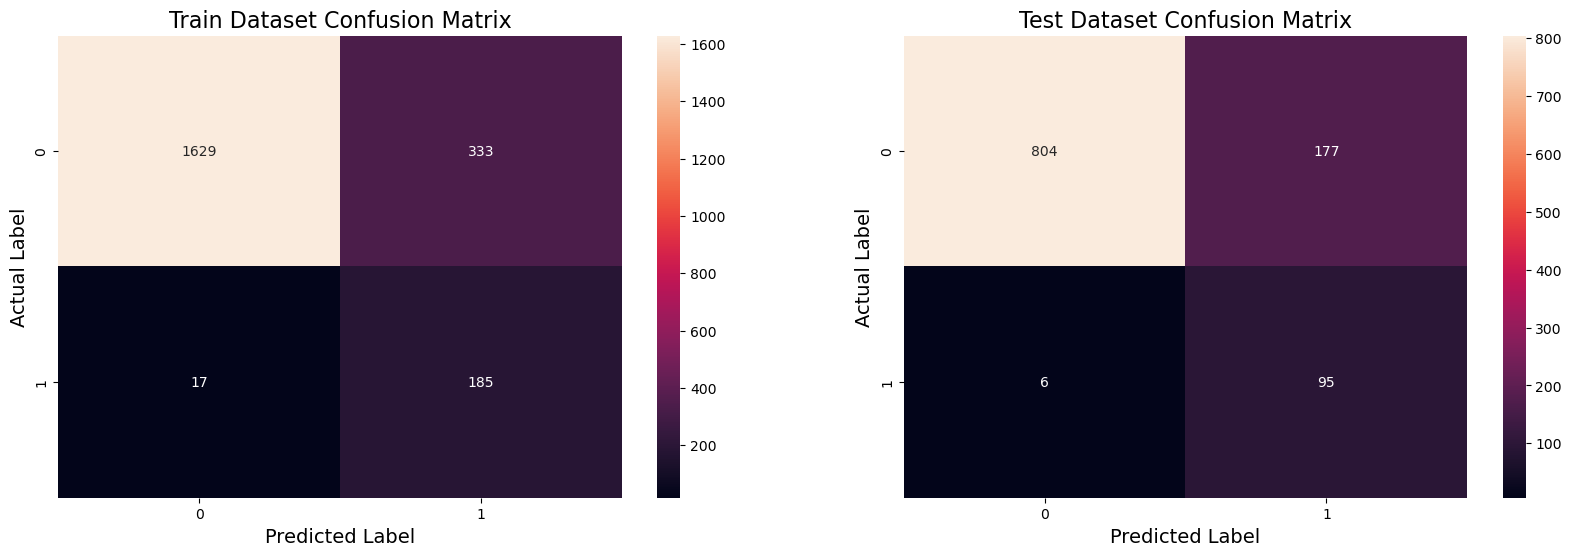

Best Threshold = 0.0841
Model AUC is : 0.9527
Model F1 Score is : 0.5094
						Number of base learners =  200
Train AUC =  0.9427110142206881
Test AUC =  0.9534673650851324


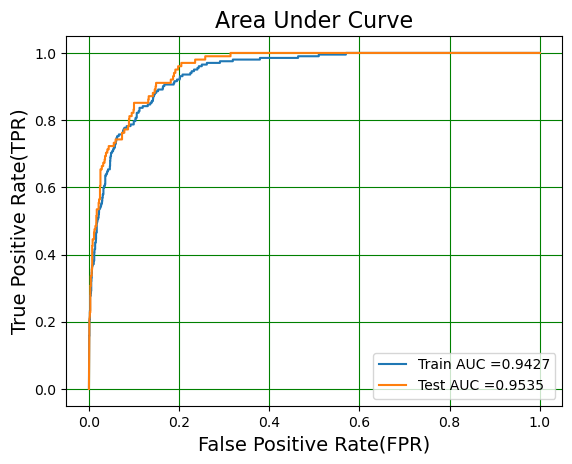

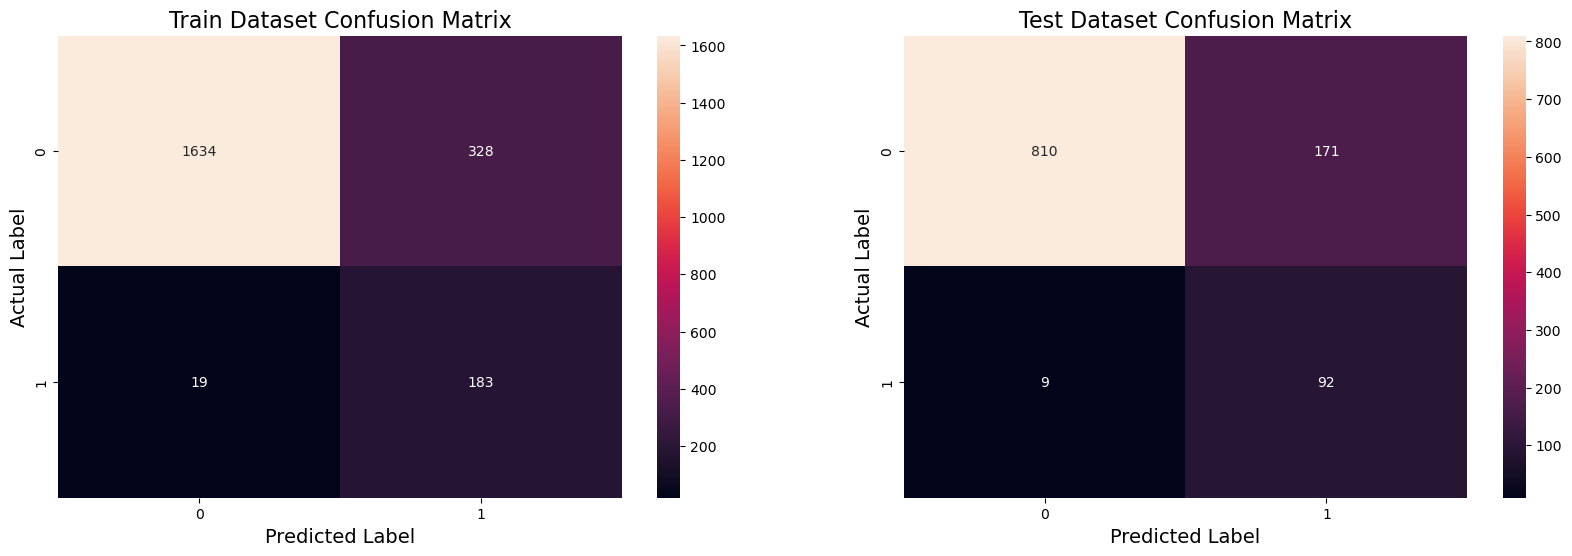

Best Threshold = 0.0825
Model AUC is : 0.9535
Model F1 Score is : 0.5055


In [19]:
# take a list of k values to iterate
list_of_k = [10,20,50,80,100,150,175,200]
for k in list_of_k:
    print("="*120)
    print("\t\t\t\t\t\tNumber of base learners = ", k)
    print("="*120)
    # create k datasets
    x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
    
    # train k base learners using these k dataset and get train data from meta model
    x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)
    
    # pass x_val through base learners to generate validation data for meta model
    pred_data_list = []
    for i in range(len(base_model_list)):
        x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
        # print(x_val_.shape)
        pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
        # pred_data = model_list[i].predict(x_val_)
        pred_data_list.append(pred_data)
    x_val_meta_model = np.vstack(pred_data_list).transpose()
    
    # train meta model (logistic regression) using train and validation data from meta model to decide best k
    log_reg = LogisticRegression(C=0.001,penalty="l2")
    log_reg.fit(x_tr_meta_model, y_te_d2)
    y_pred_meta_model = log_reg.predict_proba(x_val_meta_model)[:,1]

    # Validate LogisticRegression model
    test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

    print("Best Threshold = {:.4f}".format(best_t))
    print("Model AUC is : {:.4f}".format(test_auc))
    print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [20]:
#reference :https://stackoverflow.com/questions/8356501/python-format-tabular-output
from beautifultable import BeautifulTable
table = BeautifulTable()
table.column_headers= ["No of DT", "Meta Model", "AUC", "F1 Score"]
table.append_row(["10", "Logistic Regression", "0.9462", "0.5000"])
table.append_row(["20", "Logistic Regression", "0.9515", "0.5215"])
table.append_row(["50", "Logistic Regression", "0.9508", "0.5121"])
table.append_row(["80", "Logistic Regression", "0.9526", "0.5028"])
table.append_row(["100", "Logistic Regression", "0.9524", "0.5314"])
table.append_row(["150", "Logistic Regression", "0.9538", "0.4987"])
table.append_row(["175", "Logistic Regression", "0.9527", "0.5110"])
table.append_row(["200", "Logistic Regression", "0.9521", "0.5306"])
print(table)

+----------+---------------------+-------+----------+
| No of DT |     Meta Model      |  AUC  | F1 Score |
+----------+---------------------+-------+----------+
|    10    | Logistic Regression | 0.946 |   0.5    |
+----------+---------------------+-------+----------+
|    20    | Logistic Regression | 0.952 |  0.521   |
+----------+---------------------+-------+----------+
|    50    | Logistic Regression | 0.951 |  0.512   |
+----------+---------------------+-------+----------+
|    80    | Logistic Regression | 0.953 |  0.503   |
+----------+---------------------+-------+----------+
|   100    | Logistic Regression | 0.952 |  0.531   |
+----------+---------------------+-------+----------+
|   150    | Logistic Regression | 0.954 |  0.499   |
+----------+---------------------+-------+----------+
|   175    | Logistic Regression | 0.953 |  0.511   |
+----------+---------------------+-------+----------+
|   200    | Logistic Regression | 0.952 |  0.531   |
+----------+----------------

### Observation:

If we look only at AUC and F1 Score, meta model is working best with 20 base learners. But in our case False Negative(Predicted not Fraud, but actually it is fraud) also a main factor. If we take False negative into consideration, model is working best with 50 base learners. 

In [21]:
# create 50 sampled dataset
k = 50
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

In [22]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

### Now, train different meta model on new created dataset

### Logistic Regression

In [23]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
# find best parameters for Logistic Regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_meta_model, y_te_d2)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", l

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [24]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 0.001, 'penalty': 'l2'}
roc_auc_score : 0.9375389373772223


Train AUC =  0.9425432222121295
Test AUC =  0.9531443970085082


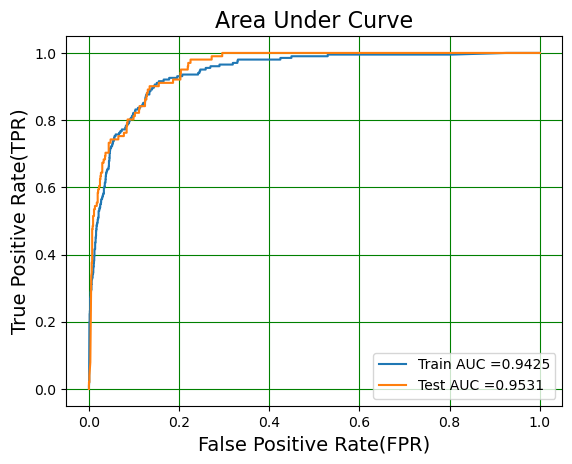

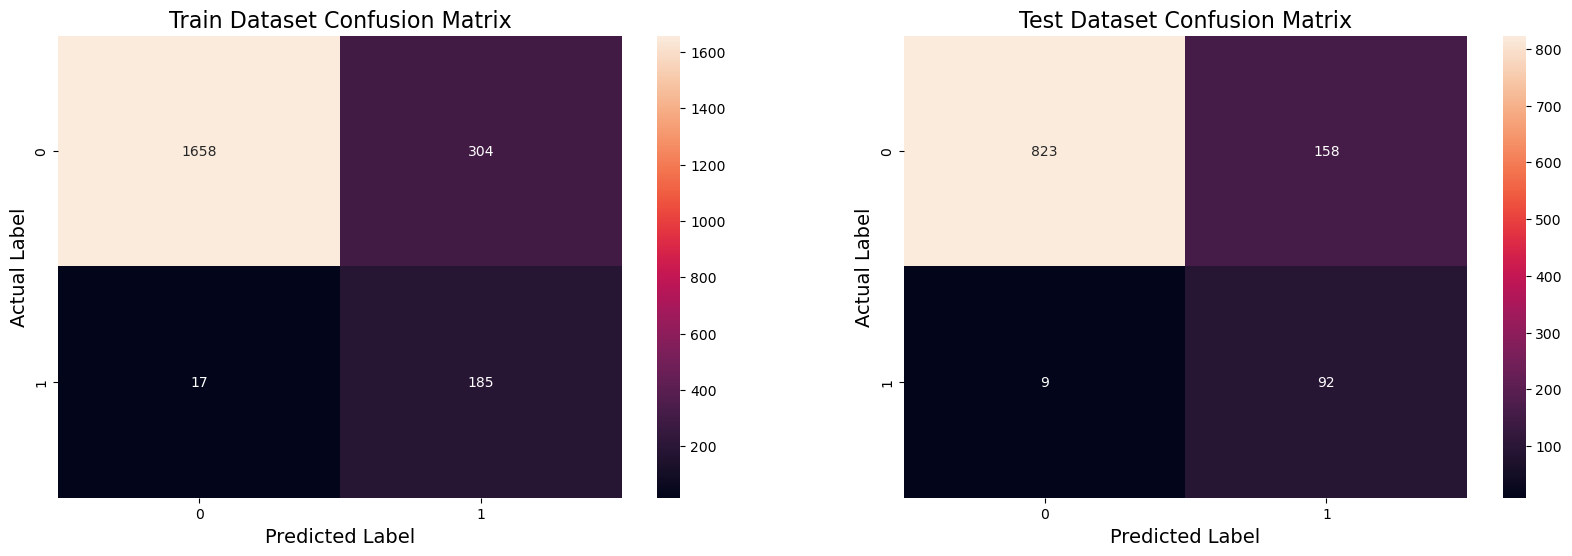

Best Threshold = 0.0710
Model AUC is : 0.9531
Model F1 Score is : 0.5242


In [25]:
# train LR using tuned parameters
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_meta_model, y_te_d2)

# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [26]:
from beautifultable import BeautifulTable
combined_table = BeautifulTable()
combined_table.column_headers= ["Model Combination", "No of base Learners", "AUC", "F1 Score"]
combined_table.append_row(["DT + LR", "50", "0.9525", "0.5443"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+


### Decision Tree

In [27]:
# find best parameters for Decision Tree
decisiontree = DecisionTreeClassifier()

parameters = {'criterion':['gini','entropy'], 'max_depth': [5, 10, 50, 100, 150, 200, 250, 500], 'min_samples_split': [5, 10, 50, 100, 150, 200, 250, 500]}

decisiontree_cv = GridSearchCV(decisiontree, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
decisiontree_cv.fit(x_tr_meta_model, y_te_d2)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 50, 100, 150, 200, 250, 500],
                         'min_samples_split': [5, 10, 50, 100, 150, 200, 250,
                                               500]},
             return_train_score=True, scoring='roc_auc')

In [28]:
print("best parameters = ",decisiontree_cv.best_params_)
print("roc_auc_score :",decisiontree_cv.best_score_)

best parameters =  {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 200}
roc_auc_score : 0.9267592213062844


Train AUC =  0.9503121183678
Test AUC =  0.9394333928805725


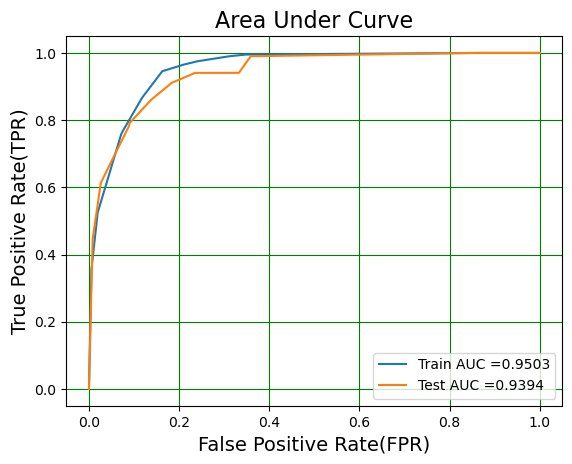

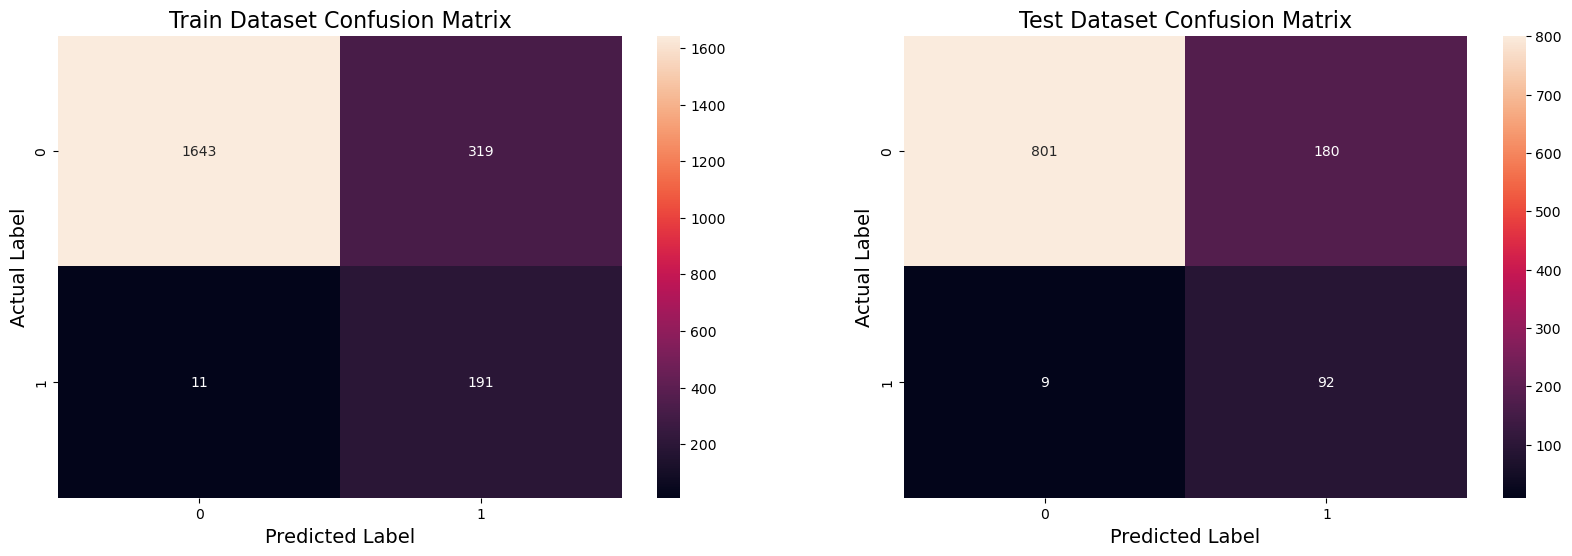

Best Threshold = 0.1538
Model AUC is : 0.9394
Model F1 Score is : 0.4933


In [29]:
decision_tree = DecisionTreeClassifier(criterion = 'entropy' ,max_depth = 5, min_samples_split = 150)
decision_tree.fit(x_tr_meta_model, y_te_d2)

# Validate Decision Tree model
test_auc, test_f1_score, best_t = validate_model(decision_tree, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [30]:
combined_table.append_row(["DT + DT", "50", "0.9141", "0.5000"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+


### Support Vector Classifier

In [31]:
# find best parameters for SVC
grid={"C":[0.5, 1.0], "penalty":["l1","l2"]}
svm_clf = svm.LinearSVC()
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
svm_cv.fit(x_tr_meta_model, y_te_d2)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py", line 1185, in _fit_libline

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.5, 1.0], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [32]:
print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 0.5, 'penalty': 'l2'}
roc_auc_score : 0.904436735548809


In [33]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc = LinearSVC(C=0.5, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_meta_model, y_te_d2)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.5))

Train AUC =  0.943999101745037
Test AUC =  0.9471593948385665


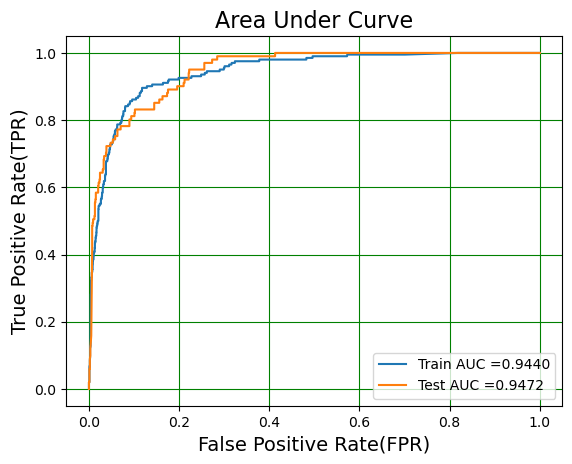

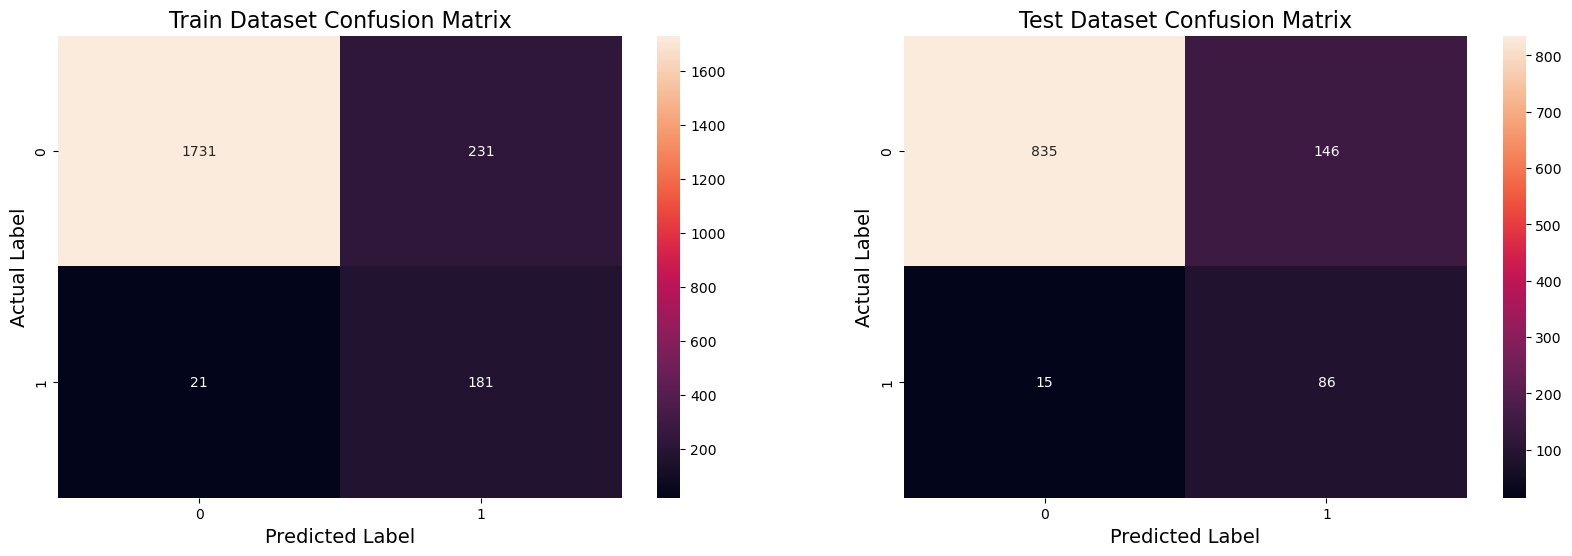

Best Threshold = 0.0950
Model AUC is : 0.9472
Model F1 Score is : 0.5165


In [34]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [35]:
combined_table.append_row(["DT + SVC", "50", "0.9424", "0.5030"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+


### Random Forest

In [36]:
# find best parameters for RF using randomized Search CV
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_meta_model, y_te_d2)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [37]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 200, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 5}
roc_auc_score : 0.9373135252052786


In [38]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=5, max_features='auto', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=400,
                       random_state=42)

Train AUC =  0.9630138472562854
Test AUC =  0.9559501821741807


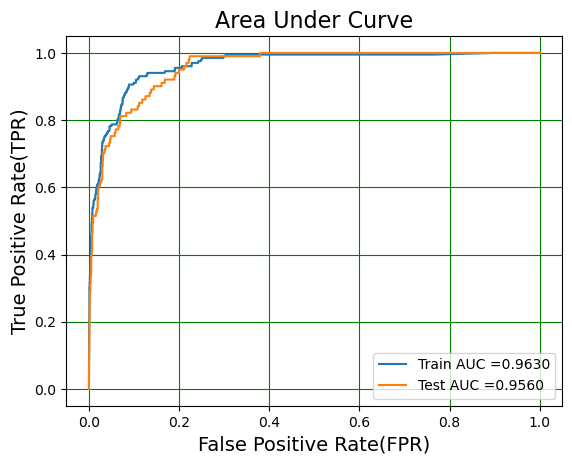

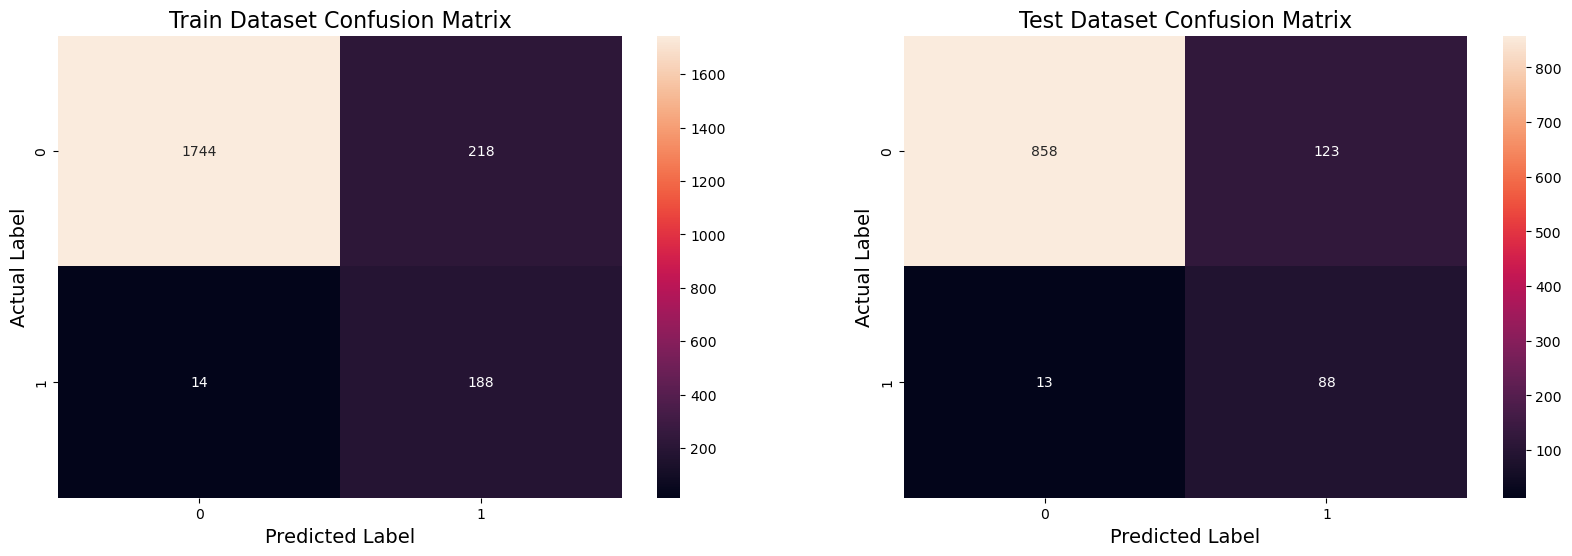

Best Threshold = 0.1197
Model AUC is : 0.9560
Model F1 Score is : 0.5641


In [39]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [40]:
combined_table.append_row(["DT + RF", "50", "0.9553", "0.5511"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+


## BaseLearner - LogisticRegression

In [41]:
# LogisticRegression
from tqdm import tqdm
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    model_list = []
    for i in range(k):
        base_learner = LogisticRegression(C=0.001,penalty="l2")
        base_learner = base_learner.fit(x_tr_list[i], y_tr_list[i])
        model_list.append(base_learner)
    
    base_model_prediction_list = []
    for j in range(k):
        #y_pred = model_list[j].predict(x_te_list[j])
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)
    
    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()
    # print(x_tr_from_base_learner.shape)
    
    return x_tr_meta_model, model_list

						Number of base learners =  10
Train AUC =  0.9719143932741898
Test AUC =  0.9412753201925698


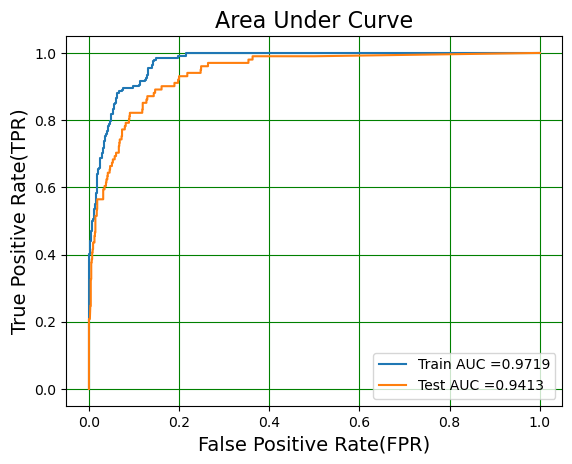

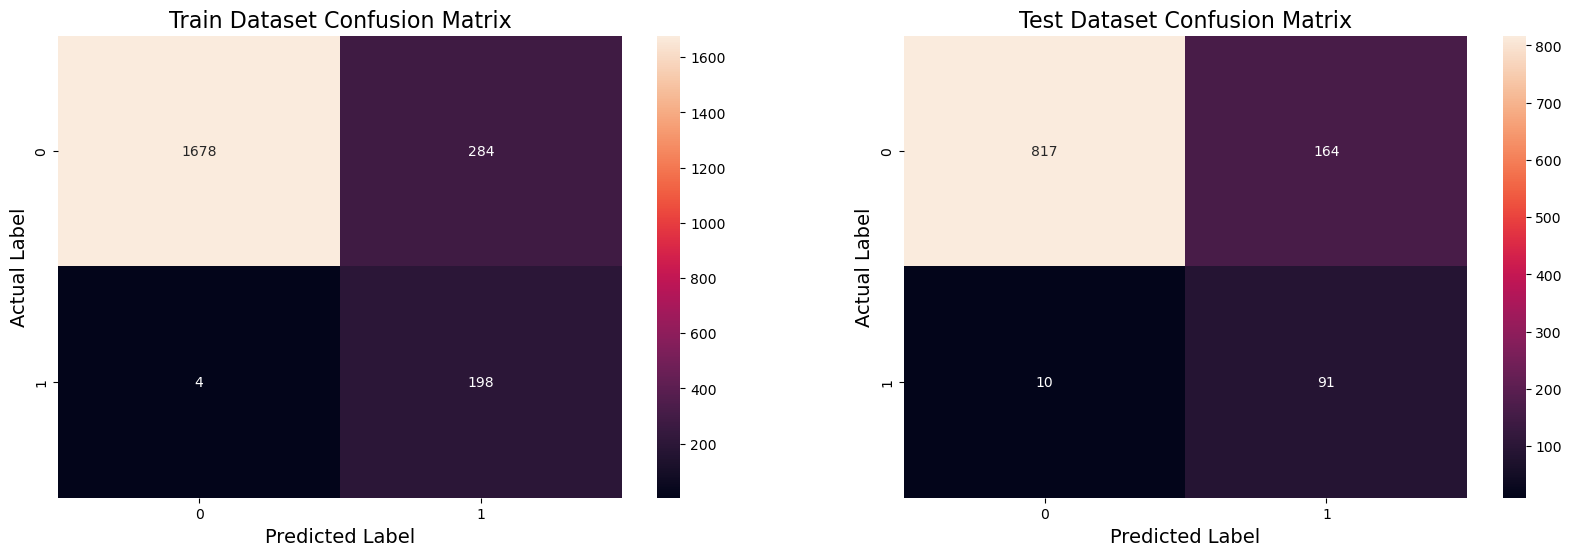

Best Threshold = 0.0947
Model AUC is : 0.9413
Model F1 Score is : 0.5112
						Number of base learners =  20
Train AUC =  0.9736326843693544
Test AUC =  0.9438338329245768


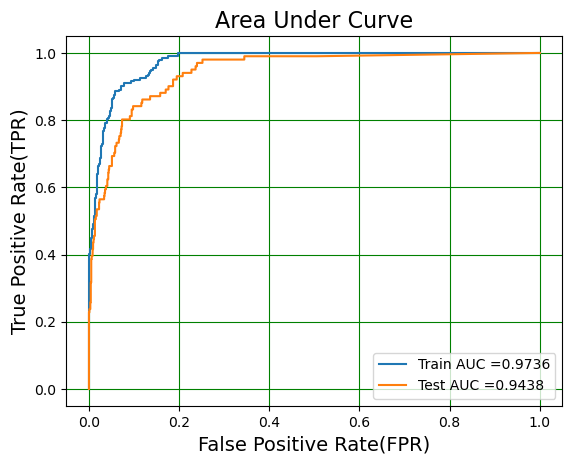

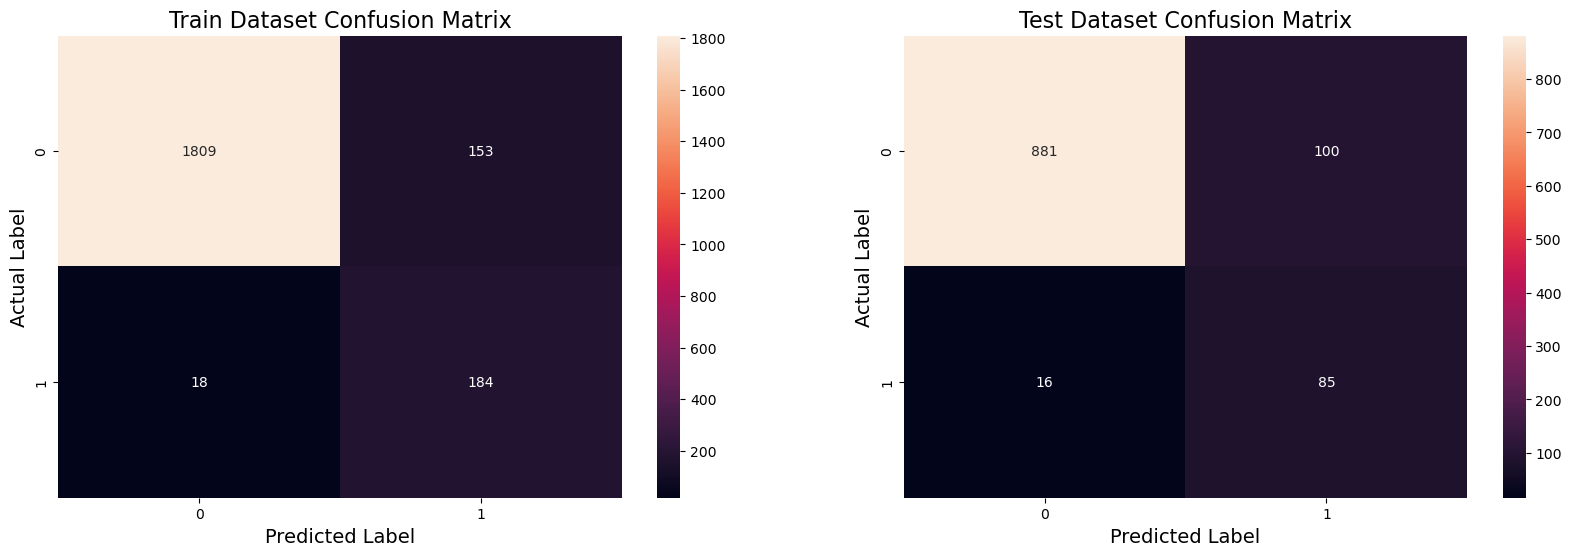

Best Threshold = 0.1870
Model AUC is : 0.9438
Model F1 Score is : 0.5944
						Number of base learners =  50
Train AUC =  0.9761457797155864
Test AUC =  0.944055873477256


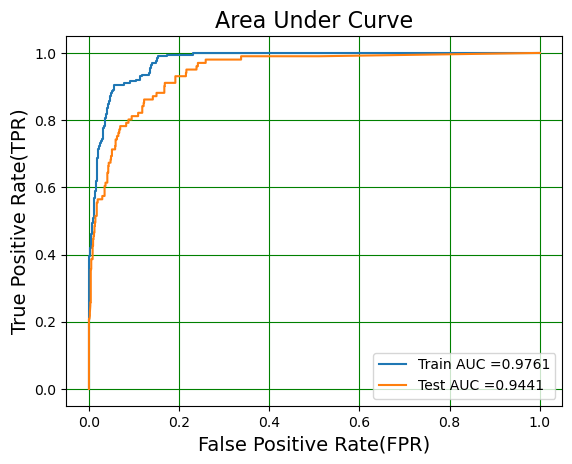

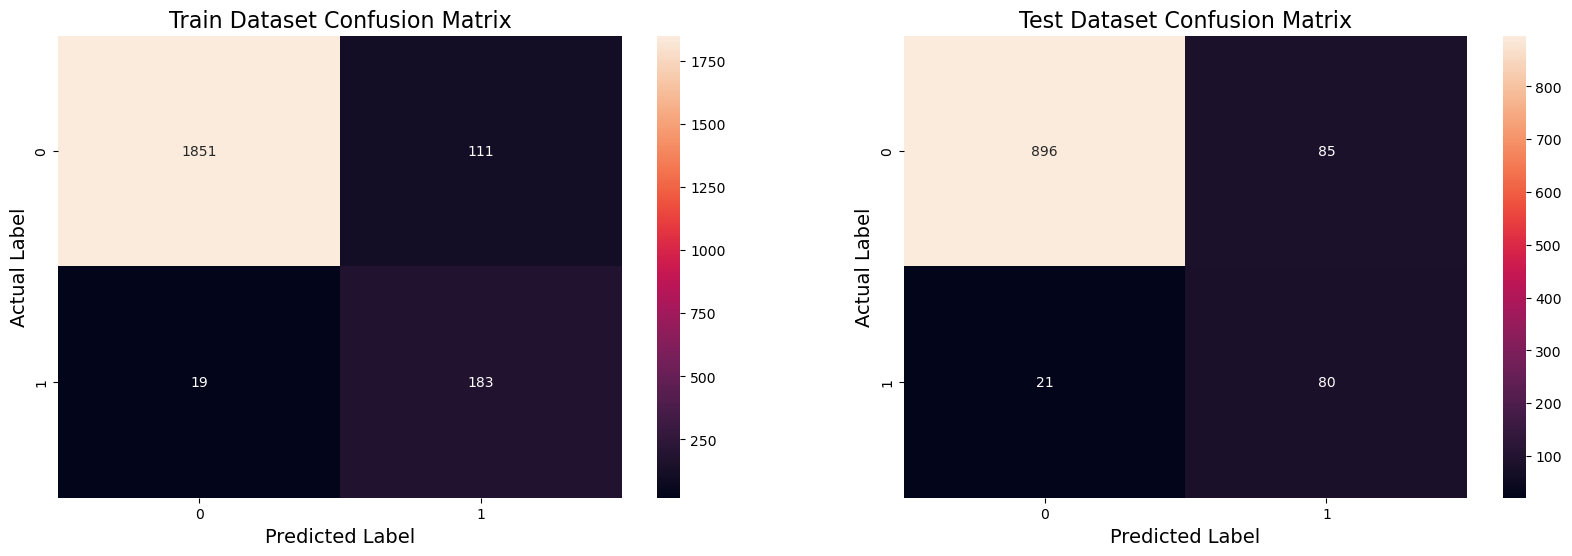

Best Threshold = 0.2025
Model AUC is : 0.9441
Model F1 Score is : 0.6015
						Number of base learners =  80
Train AUC =  0.9765242579303802
Test AUC =  0.9470180963050434


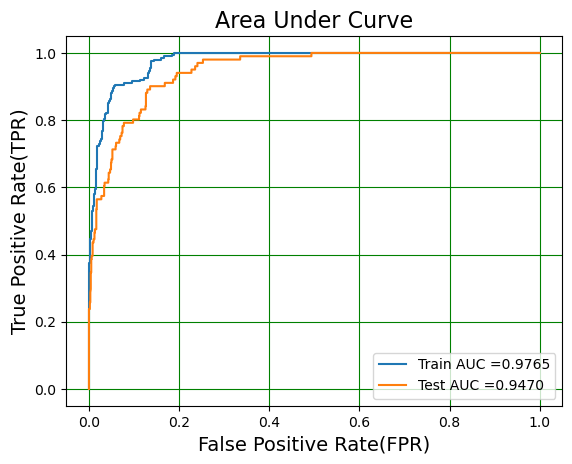

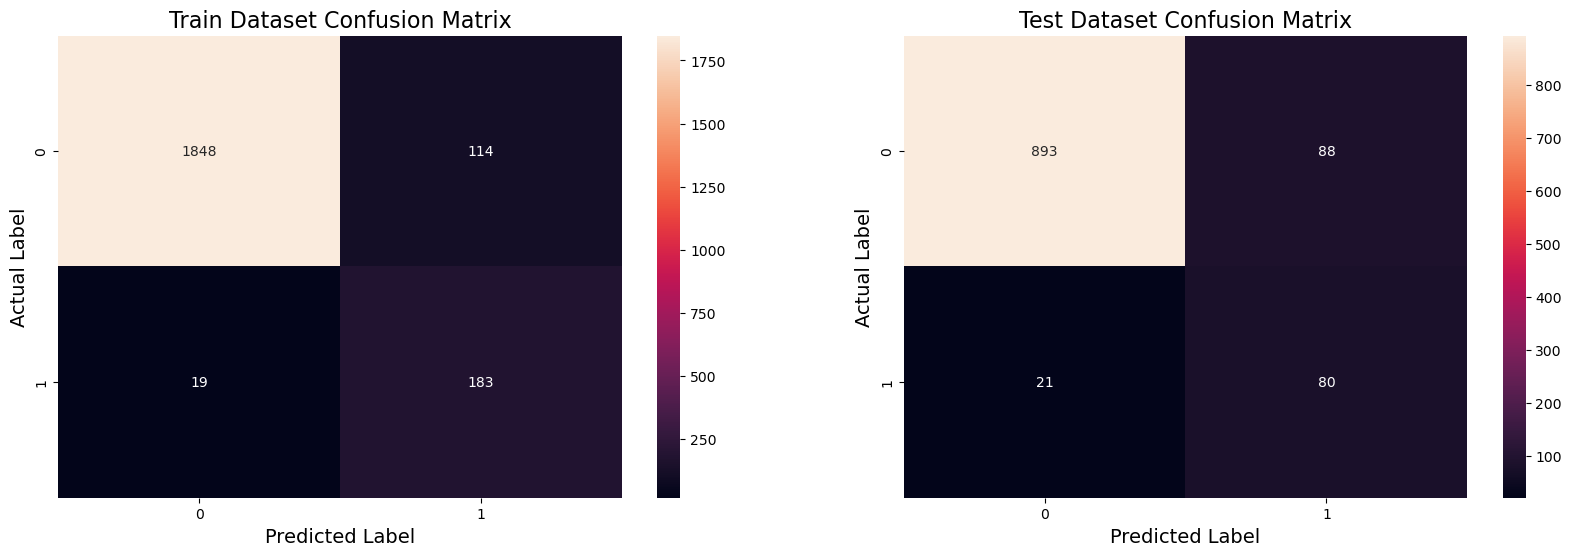

Best Threshold = 0.1950
Model AUC is : 0.9470
Model F1 Score is : 0.5948
						Number of base learners =  100
Train AUC =  0.9775814737437047
Test AUC =  0.9440205488438753


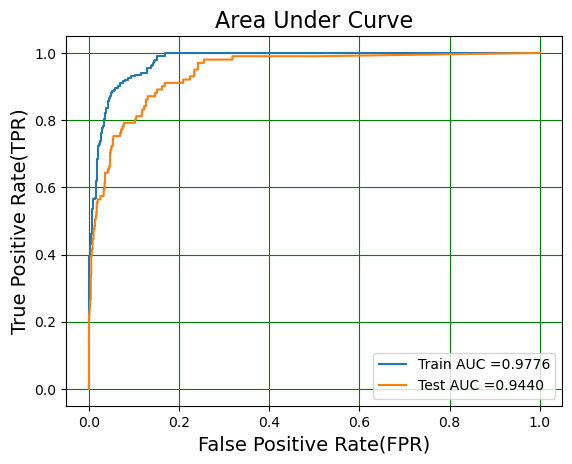

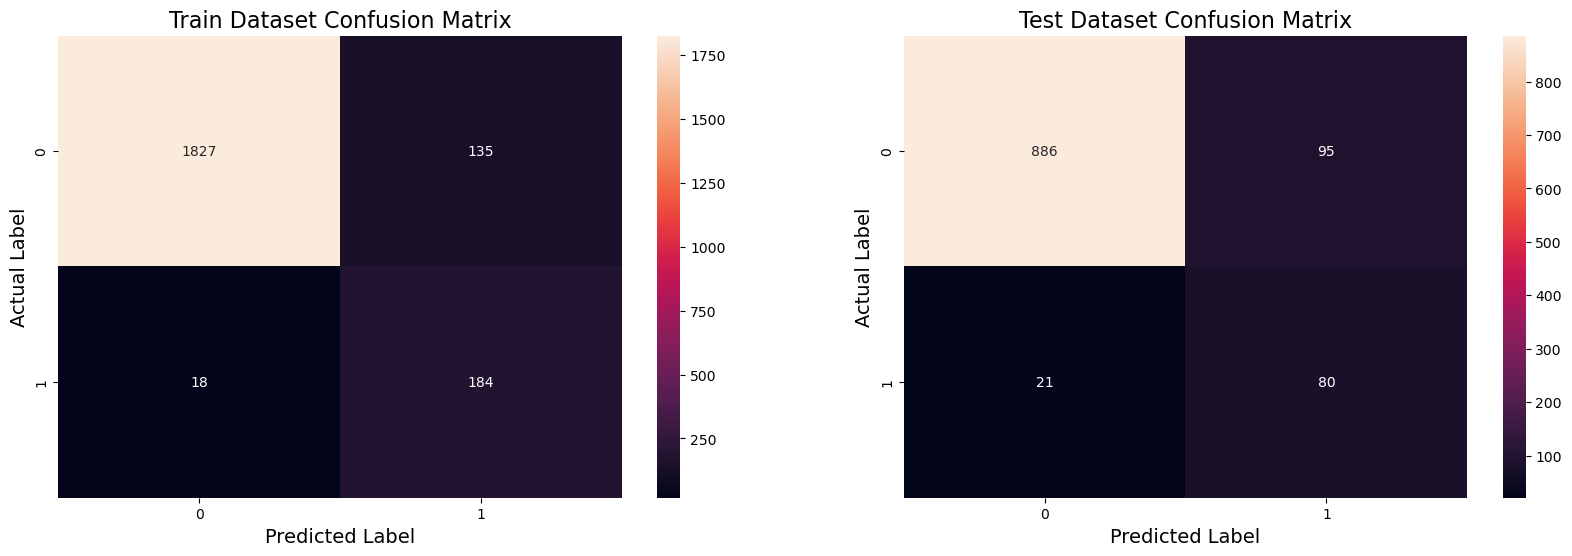

Best Threshold = 0.1859
Model AUC is : 0.9440
Model F1 Score is : 0.5797
						Number of base learners =  150
Train AUC =  0.9775158708531404
Test AUC =  0.9456757602365742


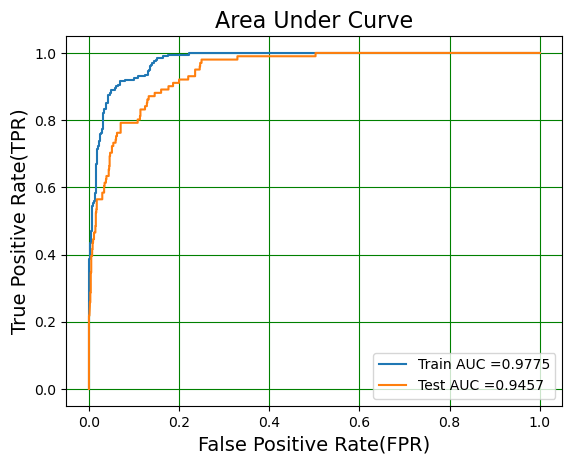

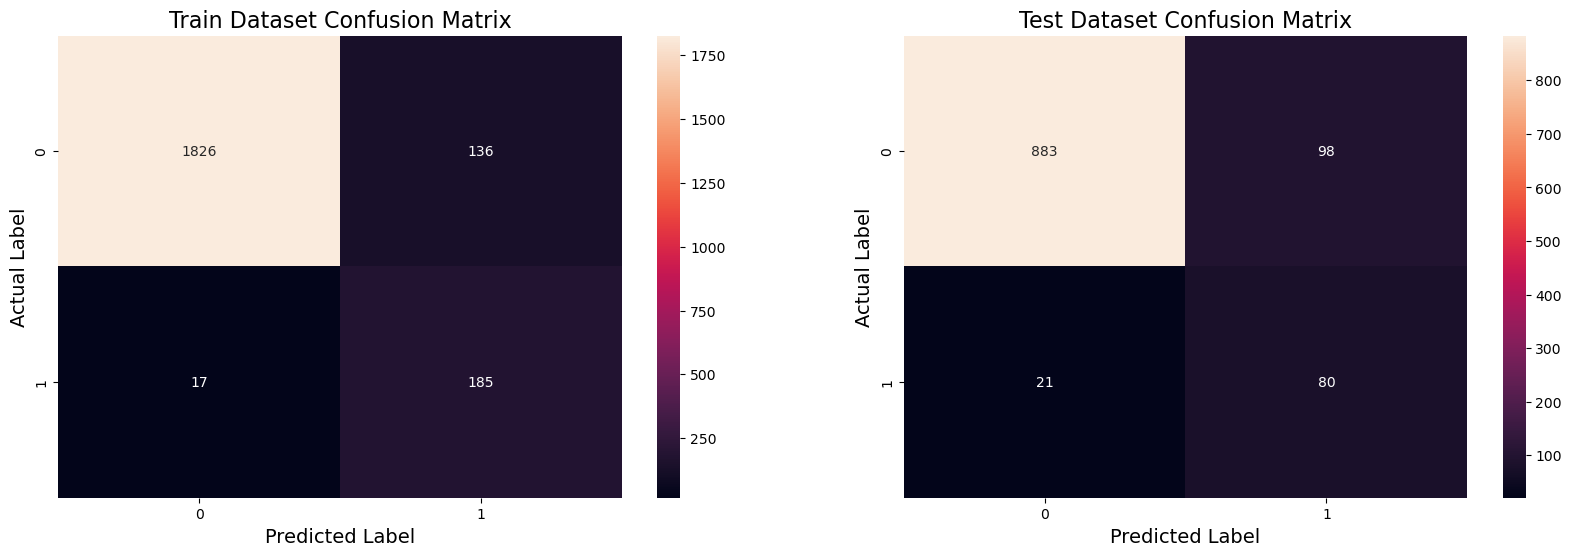

Best Threshold = 0.1886
Model AUC is : 0.9457
Model F1 Score is : 0.5735


In [42]:
# take a list of k values to iterate
list_of_k = [10,20,50,80,100,150]
for k in list_of_k:
    print("="*120)
    print("\t\t\t\t\t\tNumber of base learners = ", k)
    print("="*120)
    # create k datasets
    x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
    
    # train k base learners using these k dataset and get train data from meta model
    x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)
    
    # pass x_val through base learners to generate validation data for meta model
    pred_data_list = []
    for i in range(len(base_model_list)):
        x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
        # print(x_val_.shape)
        pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
        # pred_data = model_list[i].predict(x_val_)
        pred_data_list.append(pred_data)
    x_val_meta_model = np.vstack(pred_data_list).transpose()
    
    # train meta model (RandomForestClassifier regression) using train and validation data from meta model to decide best k
    random_forest = RandomForestClassifier(n_estimators=500, min_samples_split=5, max_features='auto', max_depth=5, random_state=42)
    random_forest.fit(x_tr_meta_model, y_te_d2)
    y_pred_meta_model = random_forest.predict_proba(x_val_meta_model)[:,1]

    # Validate LogisticRegression model
    test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

    print("Best Threshold = {:.4f}".format(best_t))
    print("Model AUC is : {:.4f}".format(test_auc))
    print("Model F1 Score is : {:.4f}".format(test_f1_score))

Number of base learns, k = 80 working best when base learner is logistic regression. Now tune the meta model.

#### Meta model = Random Forest

In [43]:
# create 80 sampled dataset
k = 80
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

In [44]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

In [45]:
# find best parameters for RF using randomized Search CV
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_meta_model, y_te_d2)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [46]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 400, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 8}
roc_auc_score : 0.9280078253140764


In [47]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=10, max_features='sqrt', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_split=10,
                       n_estimators=400, random_state=42)

Train AUC =  0.9748791392900757
Test AUC =  0.9474571310342044


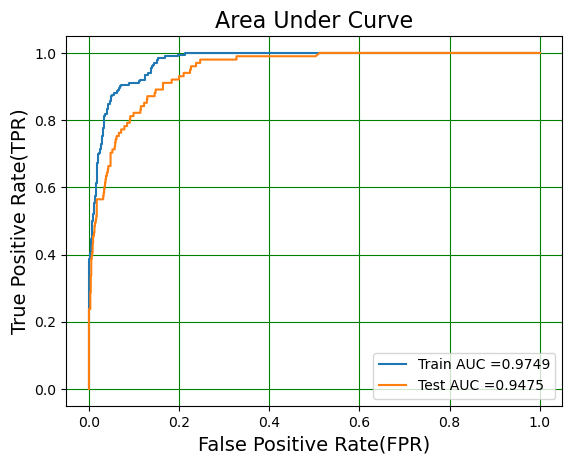

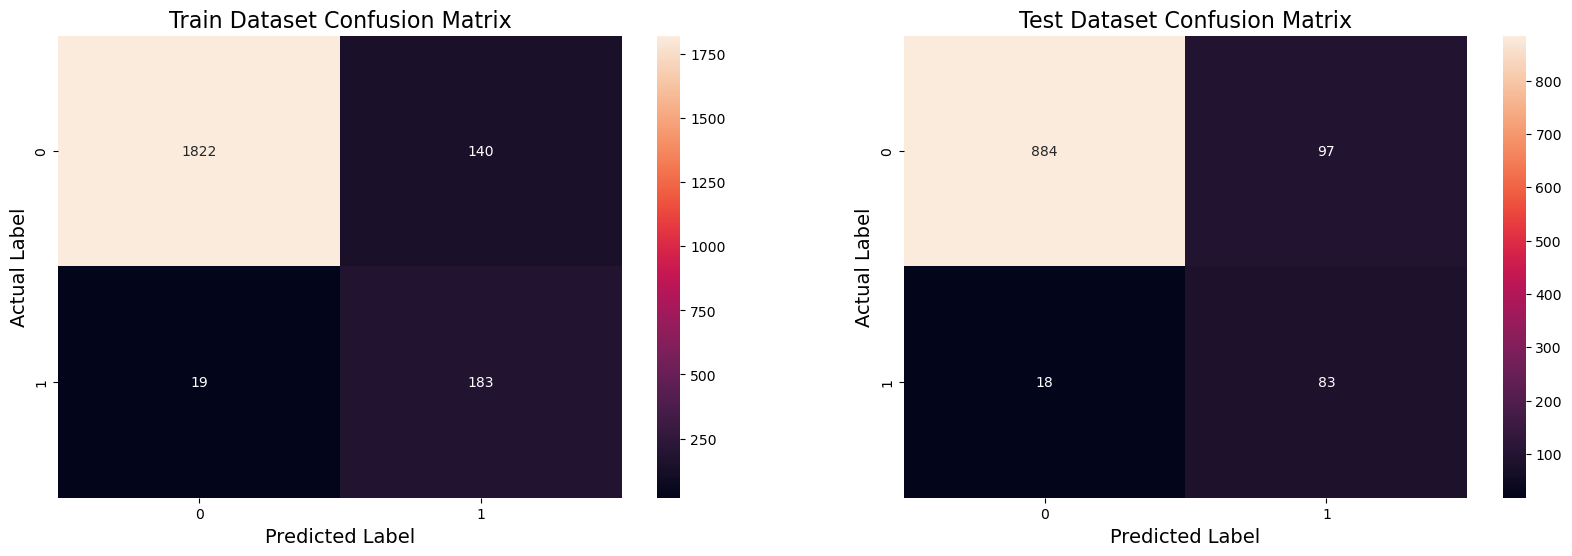

Best Threshold = 0.1835
Model AUC is : 0.9475
Model F1 Score is : 0.5907


In [48]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [49]:
combined_table.append_row(["LR + RF", "80", "0.9453", "0.6226"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+


#### MetaModel - SVC

In [50]:
# find best parameters for SVC
grid={"C":[0.5, 1.0], "penalty":["l1","l2"]}
svm_clf = svm.LinearSVC()
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
svm_cv.fit(x_tr_meta_model, y_te_d2)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py", line 1185, in _fit_libline

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.5, 1.0], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [51]:
print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 1.0, 'penalty': 'l2'}
roc_auc_score : 0.9333086931011467


In [52]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc = LinearSVC(C=1.0, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_meta_model, y_te_d2)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CalibratedClassifierCV(base_estimator=LinearSVC())

Train AUC =  0.9341246051210625
Test AUC =  0.9489306728838021


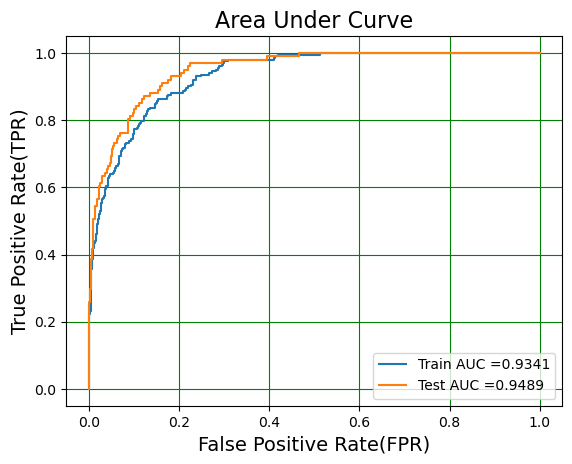

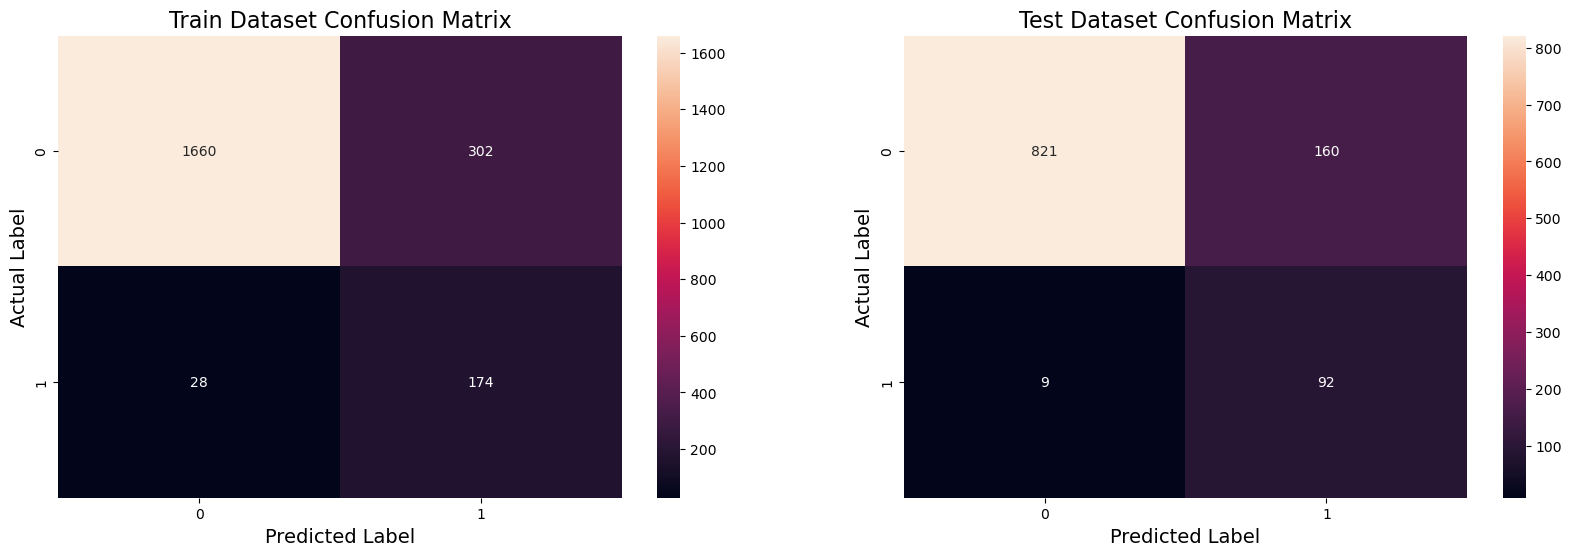

Best Threshold = 0.0571
Model AUC is : 0.9489
Model F1 Score is : 0.5212


In [53]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [54]:
combined_table.append_row(["LR + SVC", "80", "0.9485", "0.5303"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+


## BaseLearner - SVM with Linear Kernel

In [55]:
from sklearn import svm
from tqdm import tqdm
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    model_list = []
    for i in range(k):
        base_learner = svm.SVC(kernel='linear')
        base_learner_clb = CalibratedClassifierCV(base_learner)
        base_learner_clb = base_learner_clb.fit(x_tr_list[i], y_tr_list[i])
        model_list.append(base_learner_clb)
    
    base_model_prediction_list = []
    for j in range(k):
        #y_pred = model_list[j].predict(x_te_list[j])
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)
    
    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()
    # print(x_tr_from_base_learner.shape)
    
    return x_tr_meta_model, model_list

						Number of base learners =  10
Train AUC =  0.935931207799679
Test AUC =  0.960628172909034


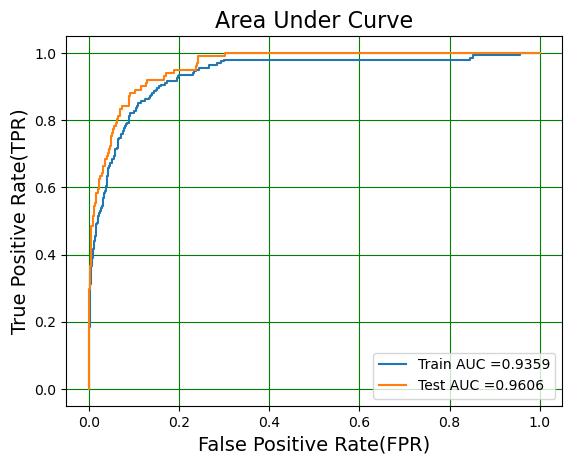

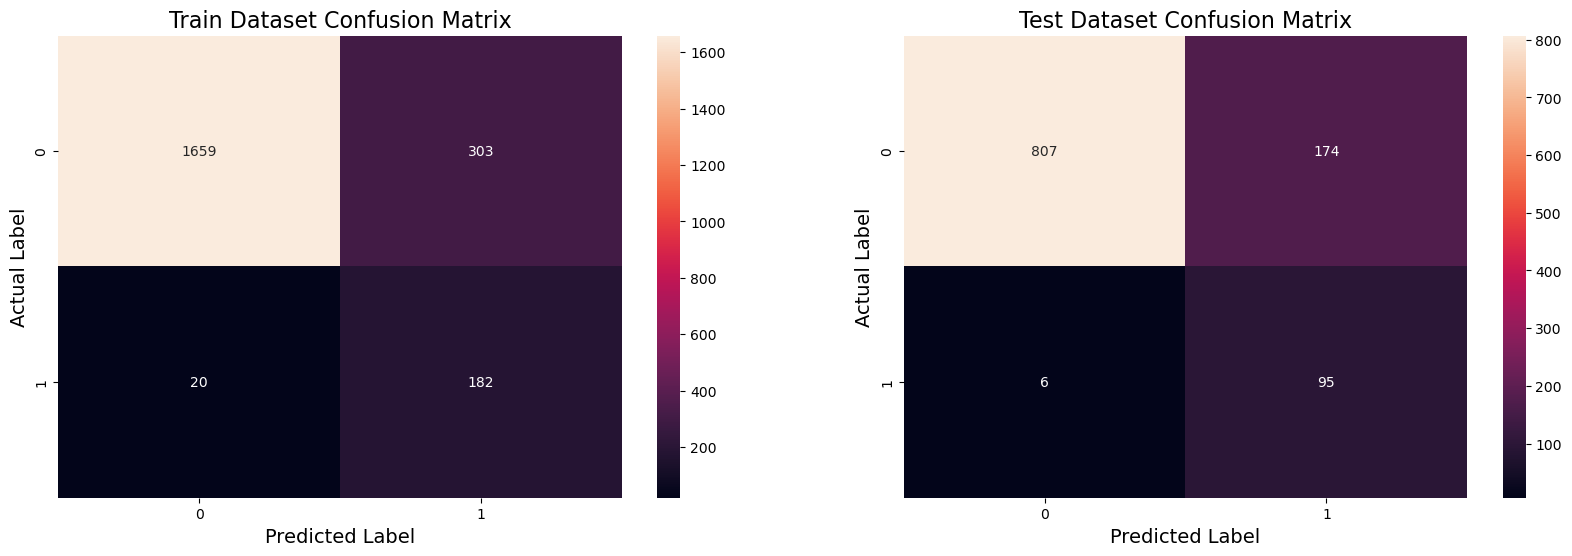

Best Threshold = 0.0932
Model AUC is : 0.9606
Model F1 Score is : 0.5135
						Number of base learners =  20
Train AUC =  0.9414267114784873
Test AUC =  0.9628283929310362


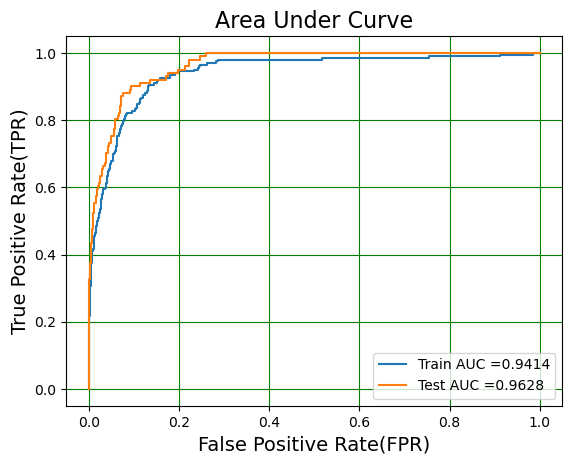

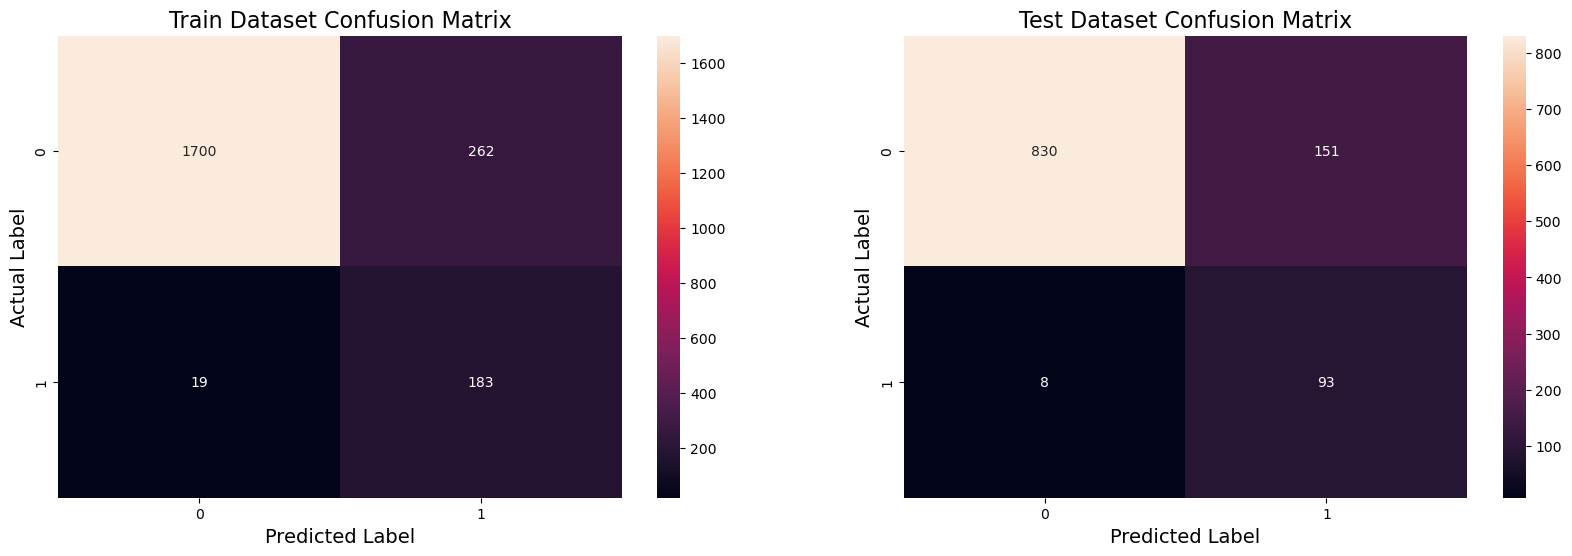

Best Threshold = 0.0932
Model AUC is : 0.9628
Model F1 Score is : 0.5391
						Number of base learners =  50
Train AUC =  0.9388177349845077
Test AUC =  0.9630807117408988


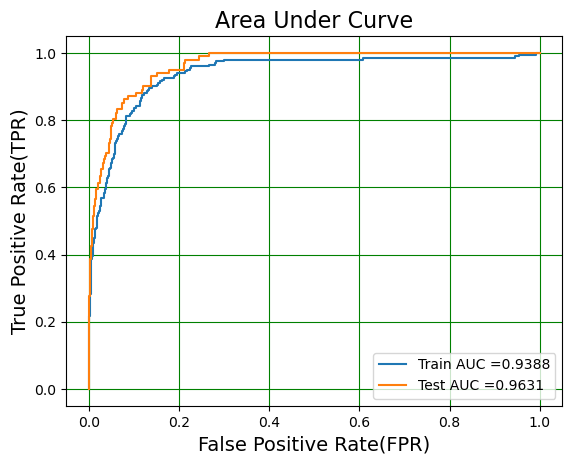

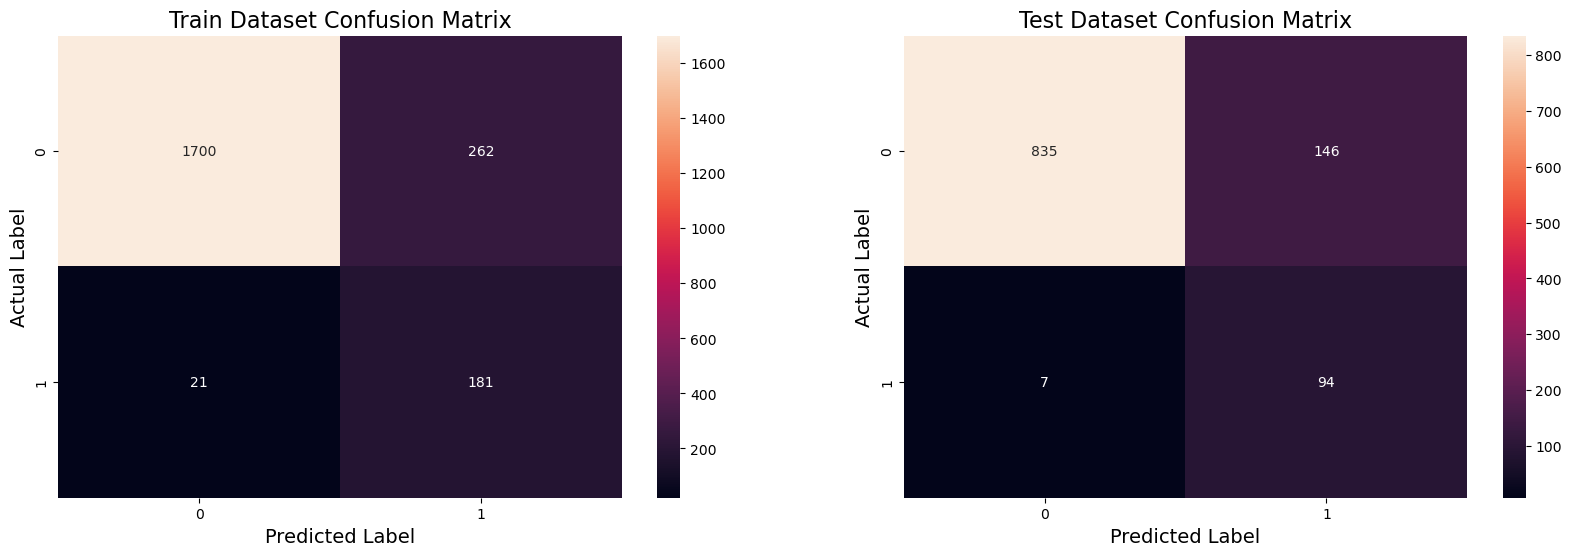

Best Threshold = 0.0928
Model AUC is : 0.9631
Model F1 Score is : 0.5513
						Number of base learners =  80
Train AUC =  0.9376772539639285
Test AUC =  0.9624145900828616


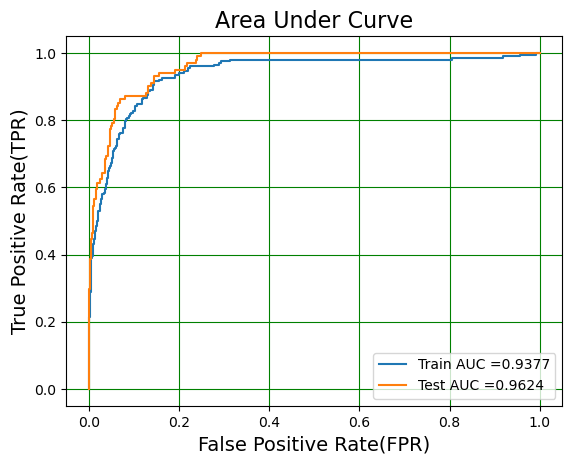

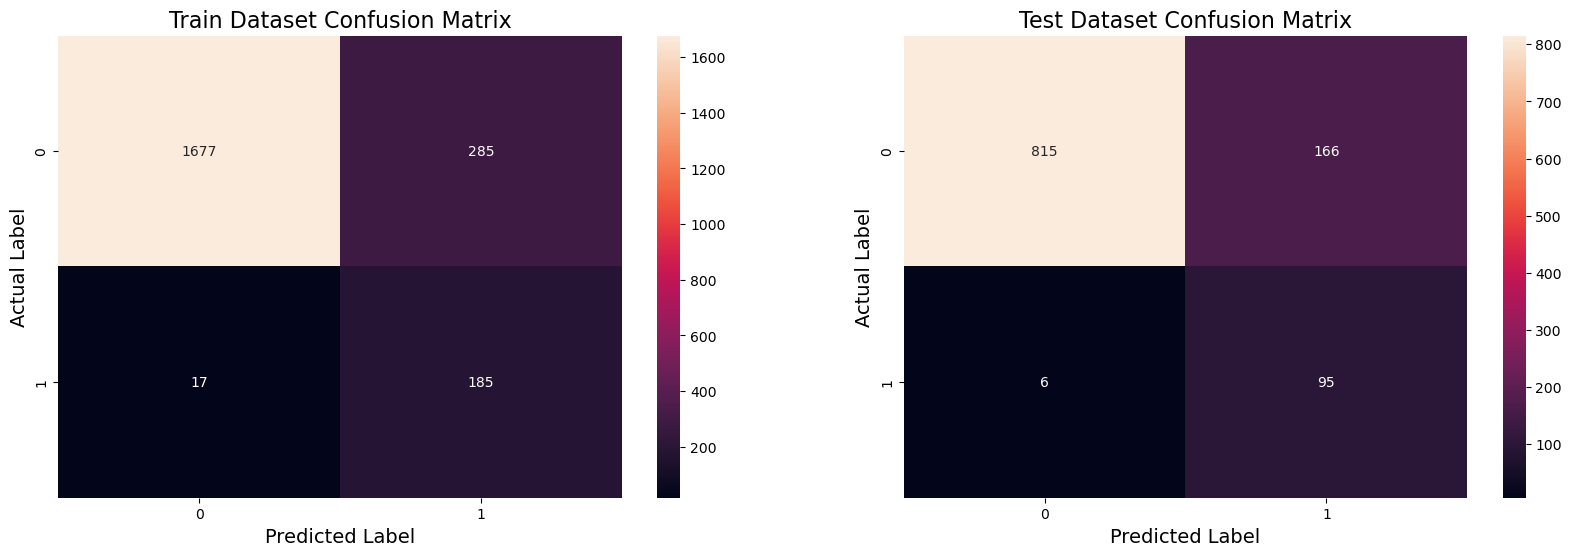

Best Threshold = 0.0924
Model AUC is : 0.9624
Model F1 Score is : 0.5249
						Number of base learners =  100
Train AUC =  0.9398623348573389
Test AUC =  0.9637771116561197


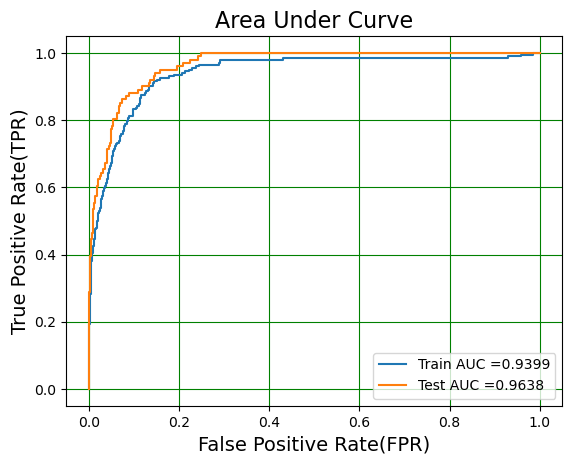

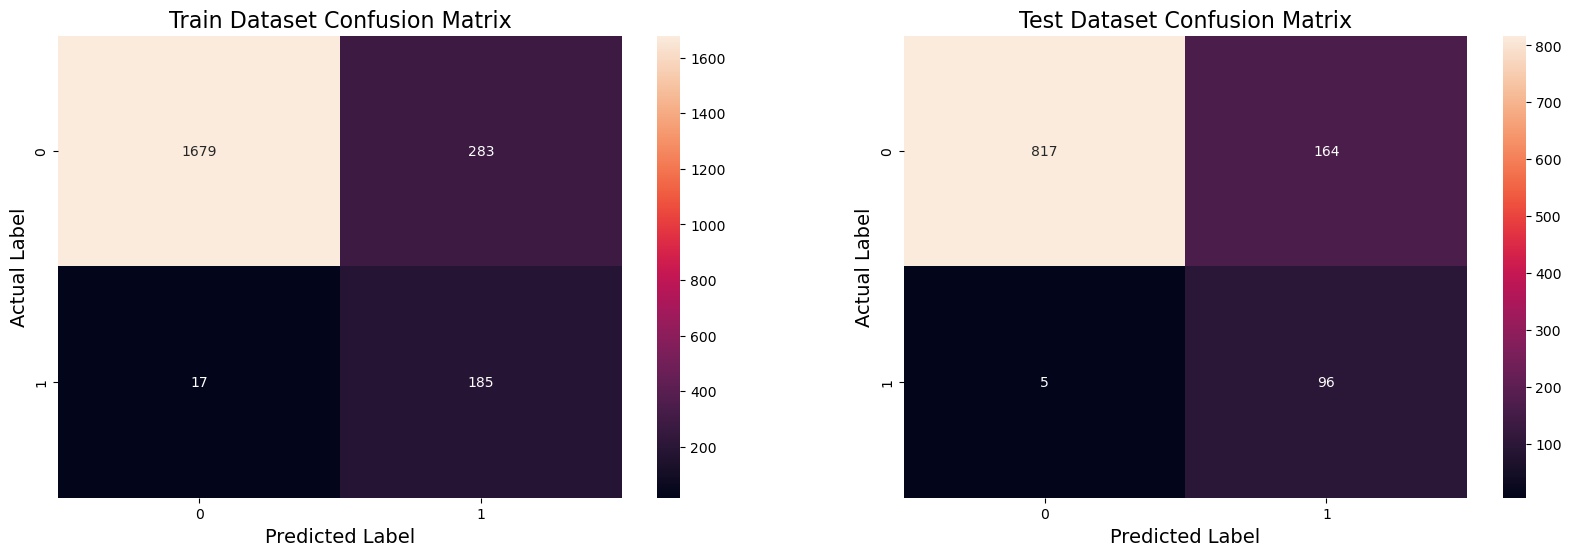

Best Threshold = 0.0921
Model AUC is : 0.9638
Model F1 Score is : 0.5319
						Number of base learners =  150
Train AUC =  0.9395570290974051
Test AUC =  0.9632321030268164


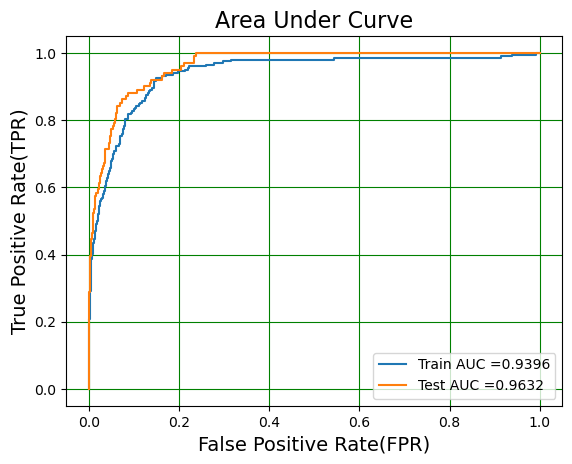

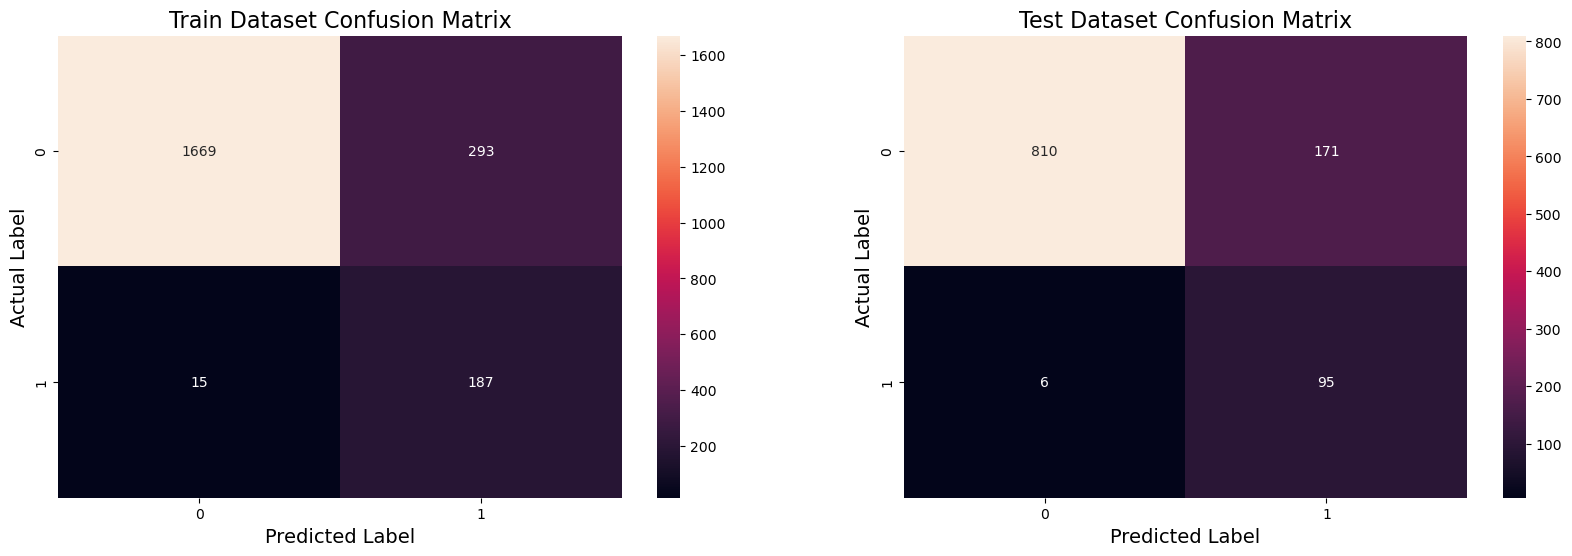

Best Threshold = 0.0914
Model AUC is : 0.9632
Model F1 Score is : 0.5177


In [56]:
# take a list of k values to iterate
list_of_k = [10,20,50,80,100,150]
for k in list_of_k:
    print("="*120)
    print("\t\t\t\t\t\tNumber of base learners = ", k)
    print("="*120)
    # create k datasets
    x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
    
    # train k base learners using these k dataset and get train data from meta model
    x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)
    
    # pass x_val through base learners to generate validation data for meta model
    pred_data_list = []
    for i in range(len(base_model_list)):
        x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
        # print(x_val_.shape)
        pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
        # pred_data = model_list[i].predict(x_val_)
        pred_data_list.append(pred_data)
    x_val_meta_model = np.vstack(pred_data_list).transpose()
    
    # train meta model (logistic regression) using train and validation data from meta model to decide best k
    log_reg = LogisticRegression(C=0.0001,penalty="l2")
    log_reg.fit(x_tr_meta_model, y_te_d2)
    y_pred_meta_model = log_reg.predict_proba(x_val_meta_model)[:,1]

    # Validate LogisticRegression model
    test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

    print("Best Threshold = {:.4f}".format(best_t))
    print("Model AUC is : {:.4f}".format(test_auc))
    print("Model F1 Score is : {:.4f}".format(test_f1_score))

Model is working best when number of base learners, k = 50 when base learner is SVM with linear kernel.

Now use k=50 and different meta model.

#### Meta Model = LogisticRegression

In [57]:
# create 50 sampled dataset
k = 50
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

In [58]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

In [59]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
# find best parameters for Logistic Regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_meta_model, y_te_d2)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", l

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [60]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 0.1, 'penalty': 'l2'}
roc_auc_score : 0.9380275956034992


Train AUC =  0.9391129479920469
Test AUC =  0.9636862768845692


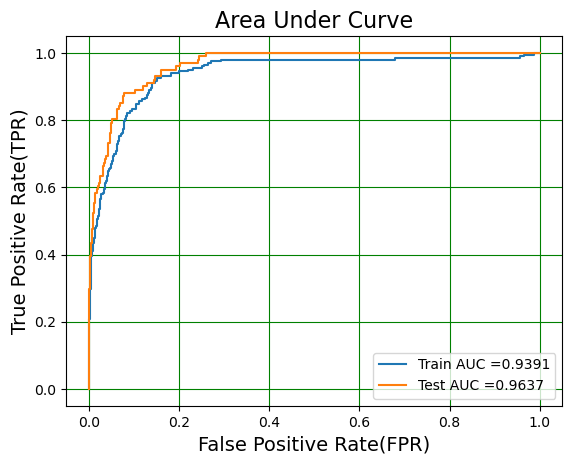

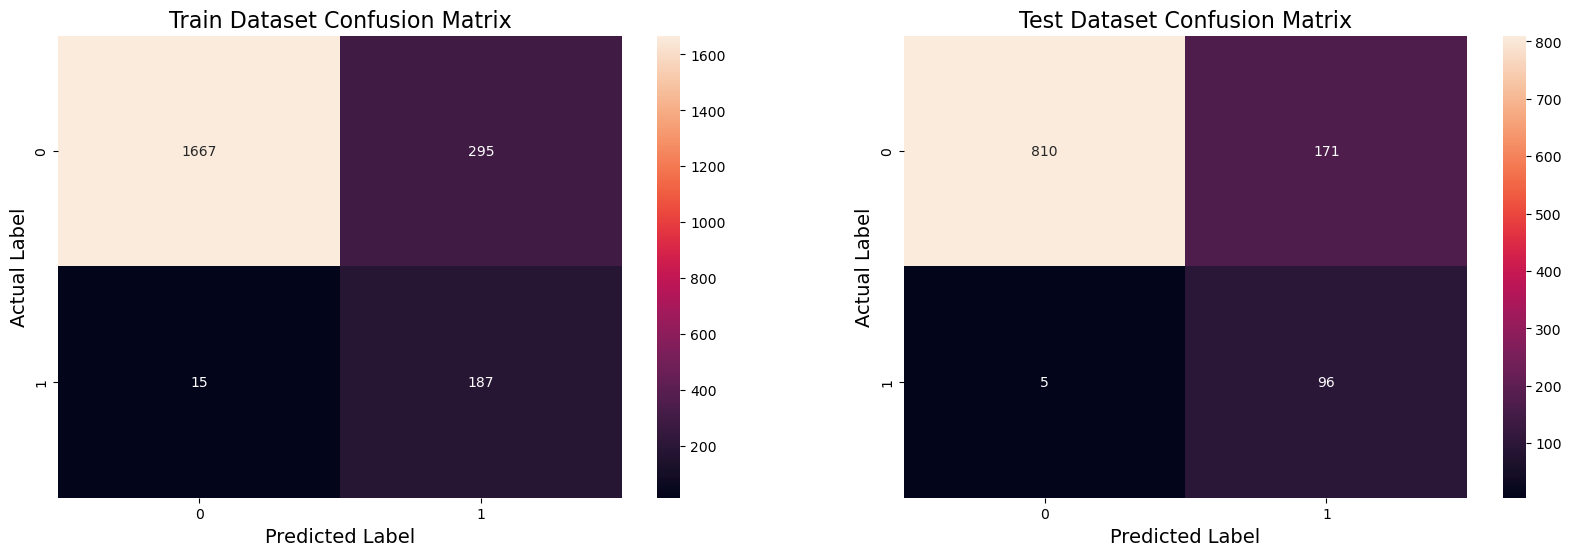

Best Threshold = 0.0525
Model AUC is : 0.9637
Model F1 Score is : 0.5217


In [61]:
# train LR using tuned parameters
log_reg = LogisticRegression(C=0.1, penalty='l2')
log_reg.fit(x_tr_meta_model, y_te_d2)

# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [62]:
combined_table.append_row(["SVM(Linear) + LR", "50", "0.9629", "0.5418"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+
| SVM(Linear) + LR  |         50          | 0.963 |  0.

#### Meta Model - Random Forest

In [63]:
# find best parameters for RF using randomized Search CV
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_meta_model, y_te_d2)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [64]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 5}
roc_auc_score : 0.9456086676431884


In [65]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=10, max_features='auto', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=400,
                       random_state=42)

Train AUC =  0.9812249573581211
Test AUC =  0.9618594887011637


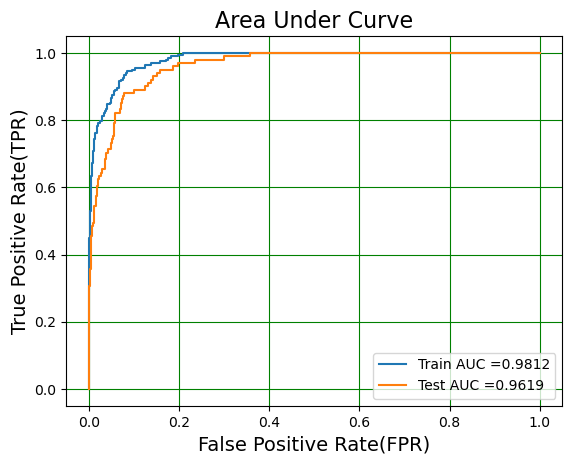

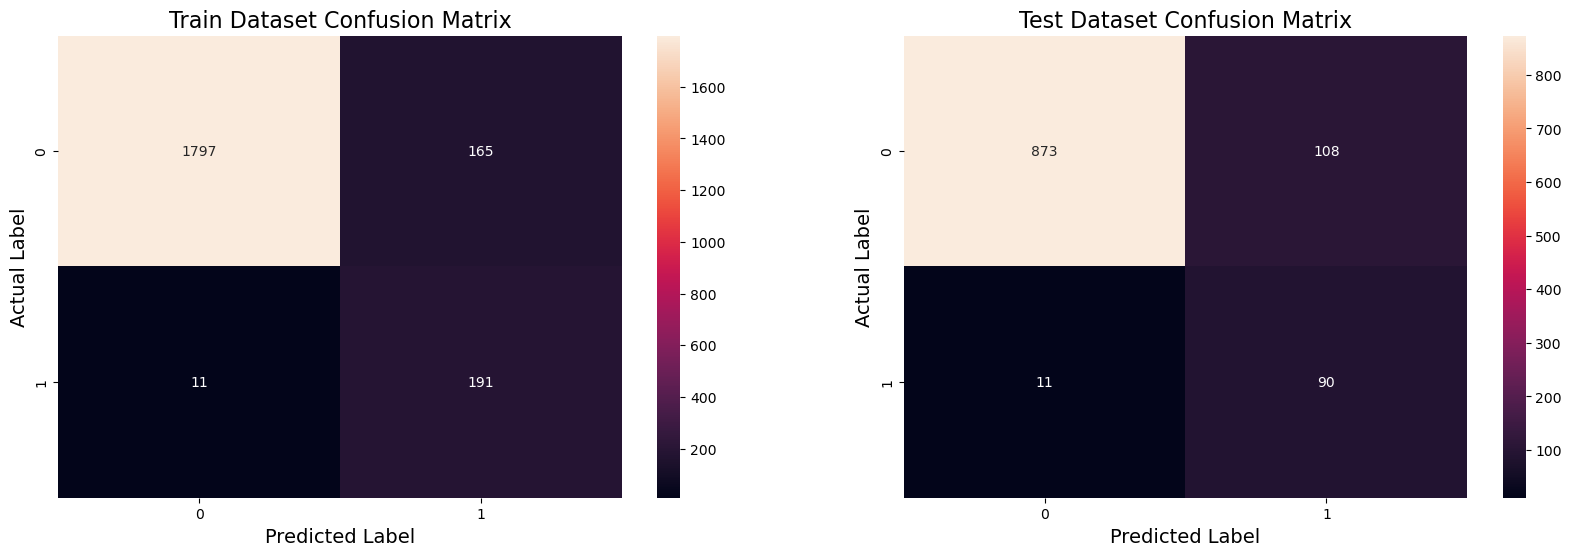

Best Threshold = 0.1547
Model AUC is : 0.9619
Model F1 Score is : 0.6020


In [66]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [67]:
combined_table.append_row(["SVM(Linear) + RF", "50", "0.9630", "0.6207"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+
| SVM(Linear) + LR  |         50          | 0.963 |  0.

## BaseLearner - SVM with rbf Kernel

In [68]:
from sklearn import svm
from tqdm import tqdm
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    model_list = []
    for i in range(k):
        base_learner = svm.SVC(kernel='rbf')
        base_learner_clb = CalibratedClassifierCV(base_learner)
        base_learner_clb = base_learner_clb.fit(x_tr_list[i], y_tr_list[i])
        model_list.append(base_learner_clb)
    
    base_model_prediction_list = []
    for j in range(k):
        #y_pred = model_list[j].predict(x_te_list[j])
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)
    
    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()
    # print(x_tr_from_base_learner.shape)
    
    return x_tr_meta_model, model_list

						Number of base learners =  10
Train AUC =  0.788473572127855
Test AUC =  0.8541597278993955


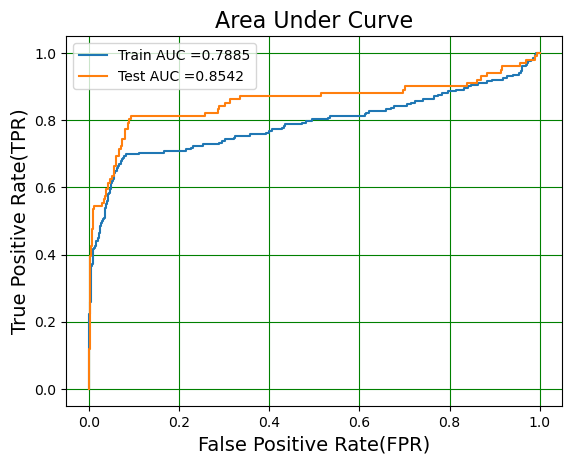

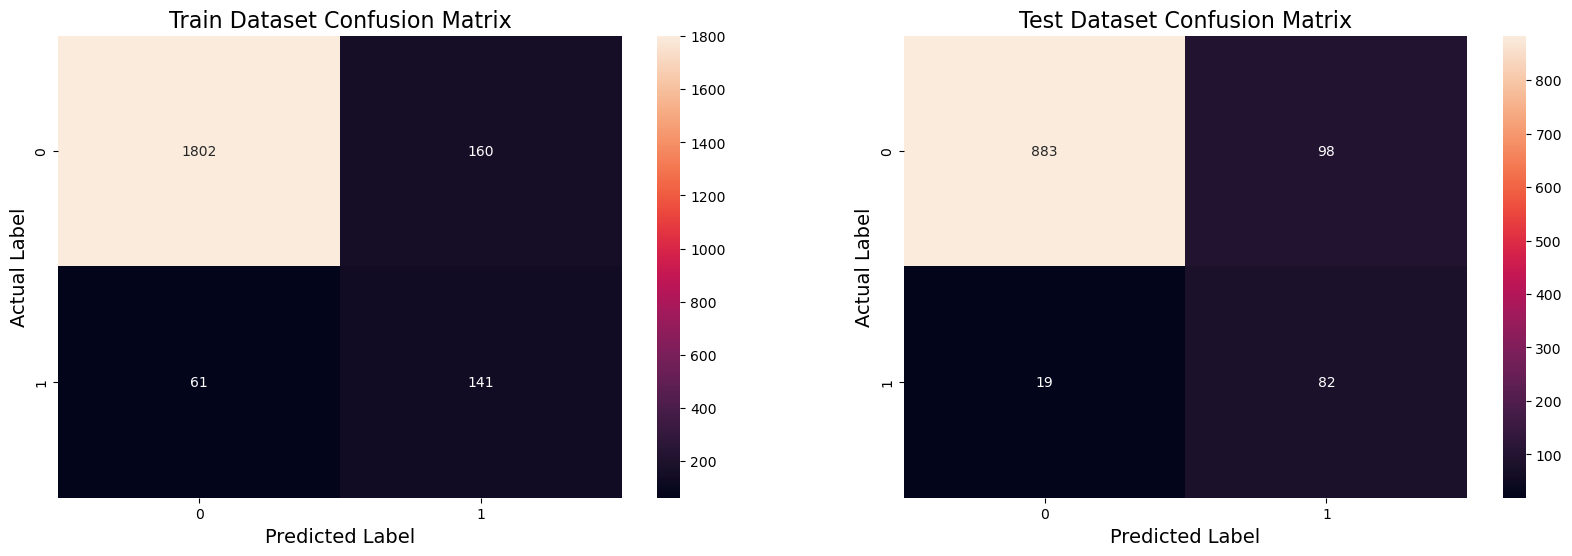

Best Threshold = 0.0919
Model AUC is : 0.8542
Model F1 Score is : 0.5836
						Number of base learners =  20
Train AUC =  0.8090350319435614
Test AUC =  0.8725487227621844


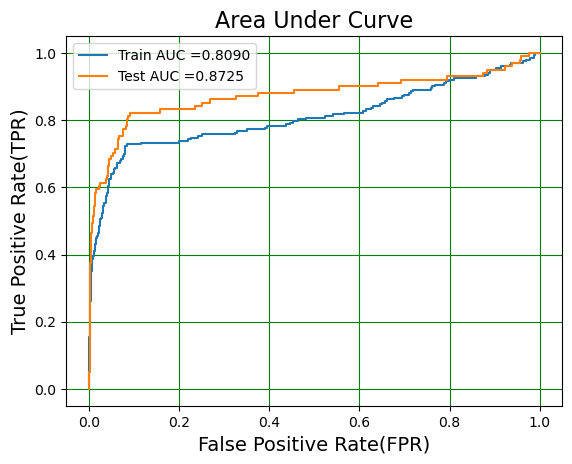

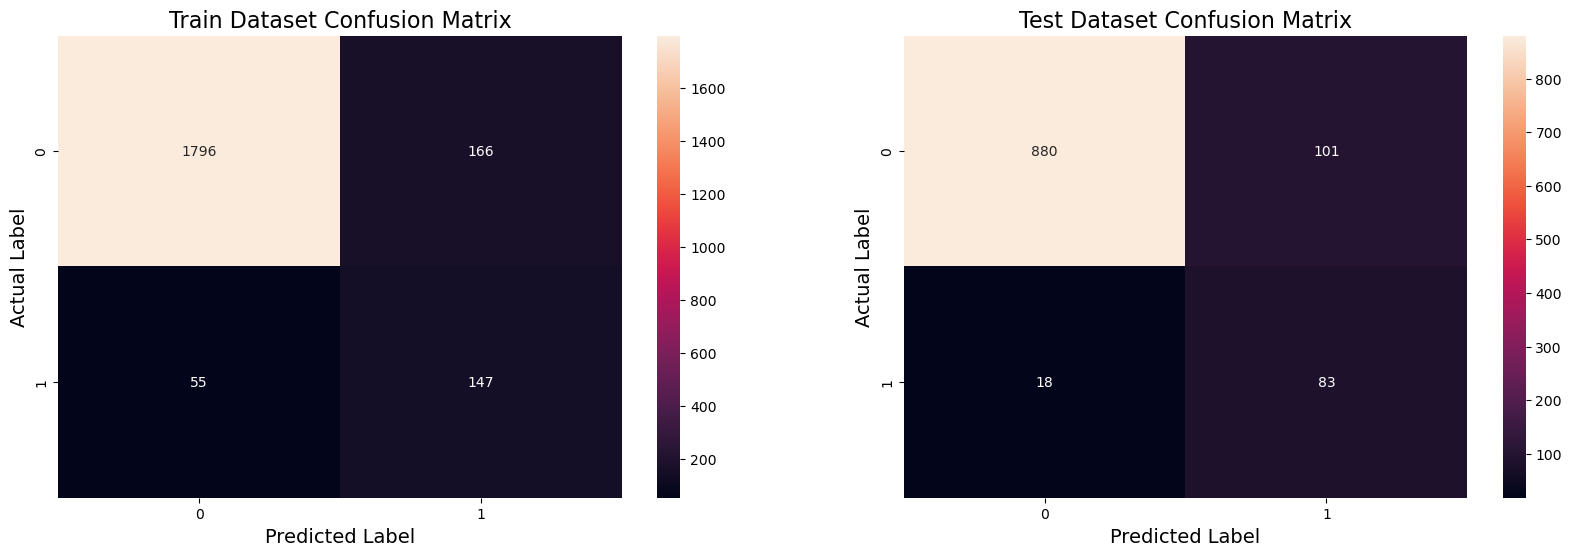

Best Threshold = 0.0903
Model AUC is : 0.8725
Model F1 Score is : 0.5825
						Number of base learners =  50
Train AUC =  0.8043015310705381
Test AUC =  0.8716000040371009


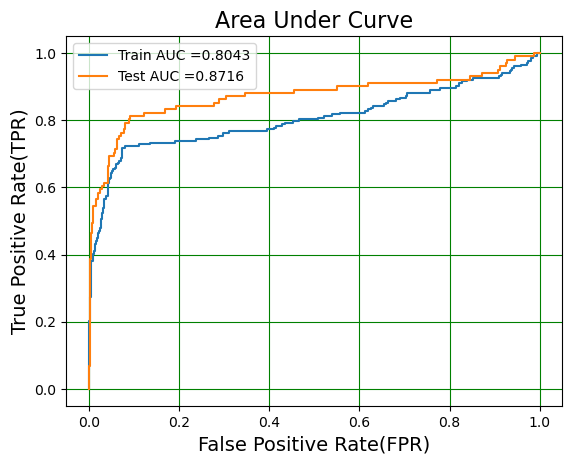

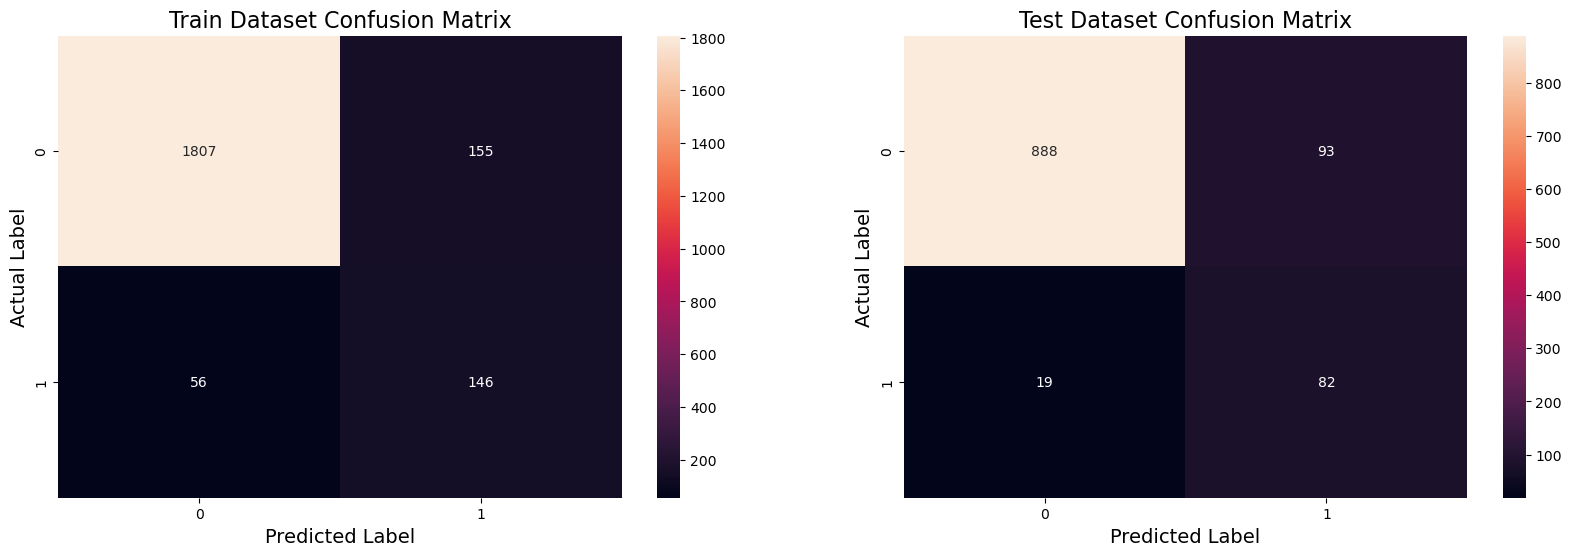

Best Threshold = 0.0862
Model AUC is : 0.8716
Model F1 Score is : 0.5942
						Number of base learners =  80
Train AUC =  0.8060627163633795
Test AUC =  0.8721651981711933


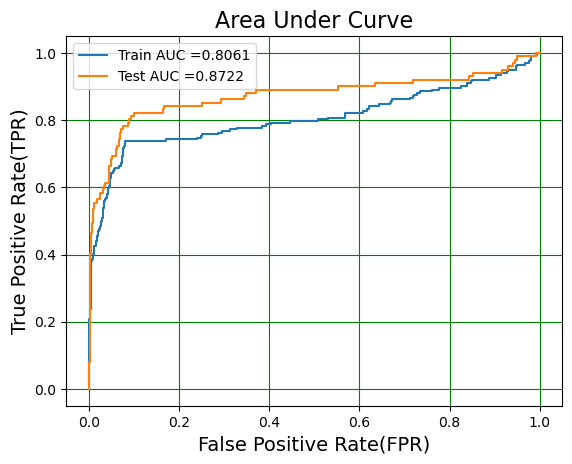

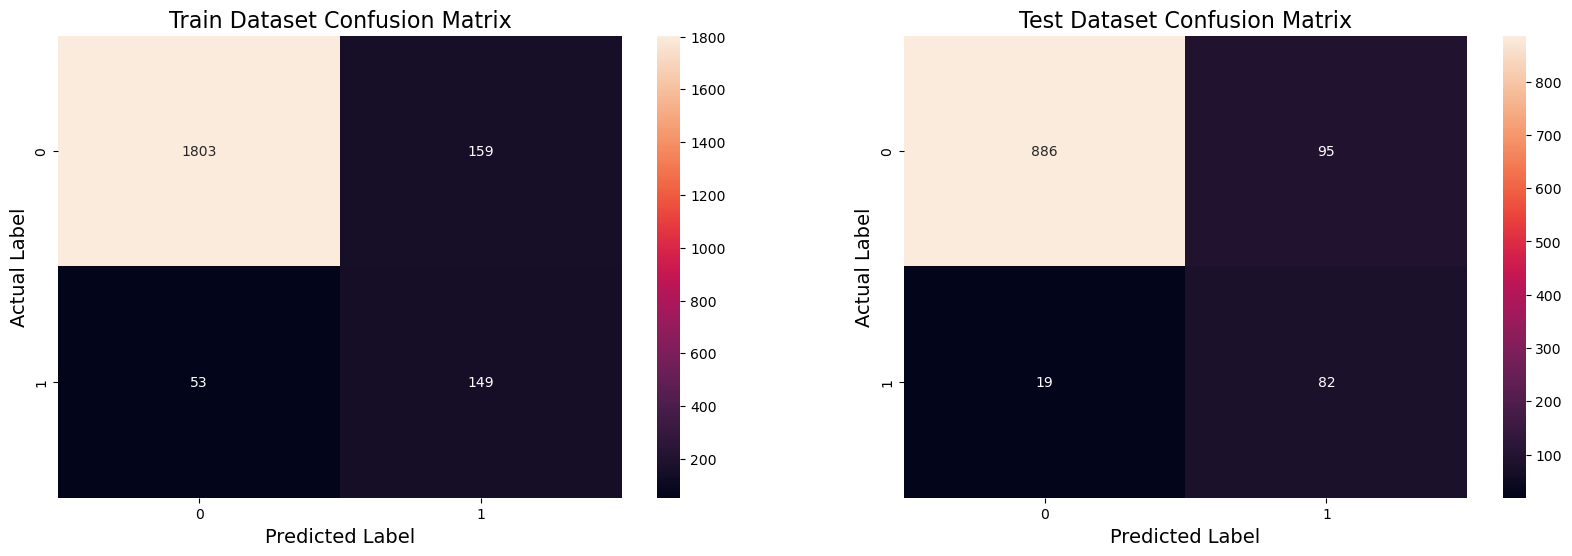

Best Threshold = 0.0825
Model AUC is : 0.8722
Model F1 Score is : 0.5899
						Number of base learners =  100
Train AUC =  0.8132235241872813
Test AUC =  0.8733359574489559


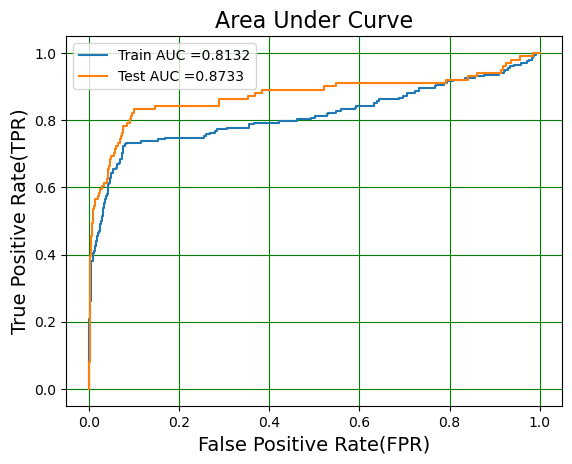

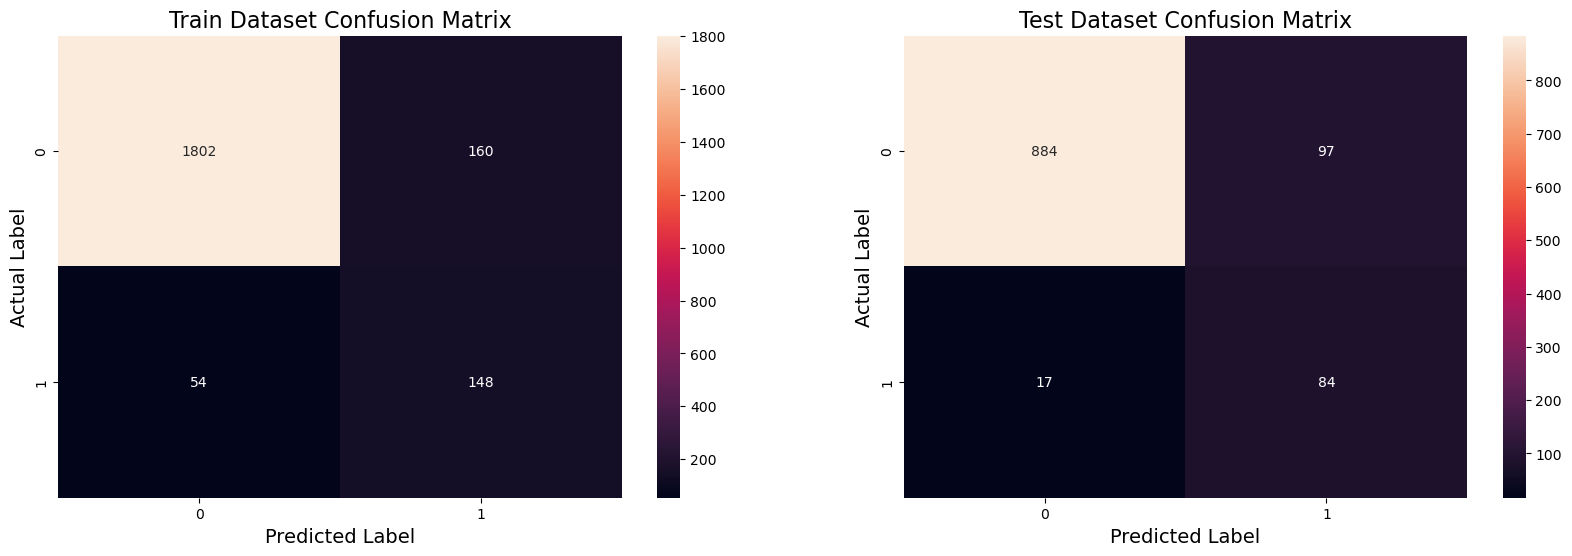

Best Threshold = 0.0799
Model AUC is : 0.8733
Model F1 Score is : 0.5957
						Number of base learners =  150
Train AUC =  0.8185474510753828
Test AUC =  0.8775547279498592


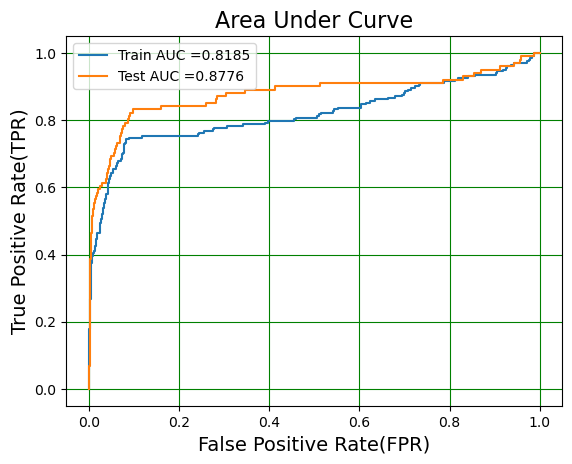

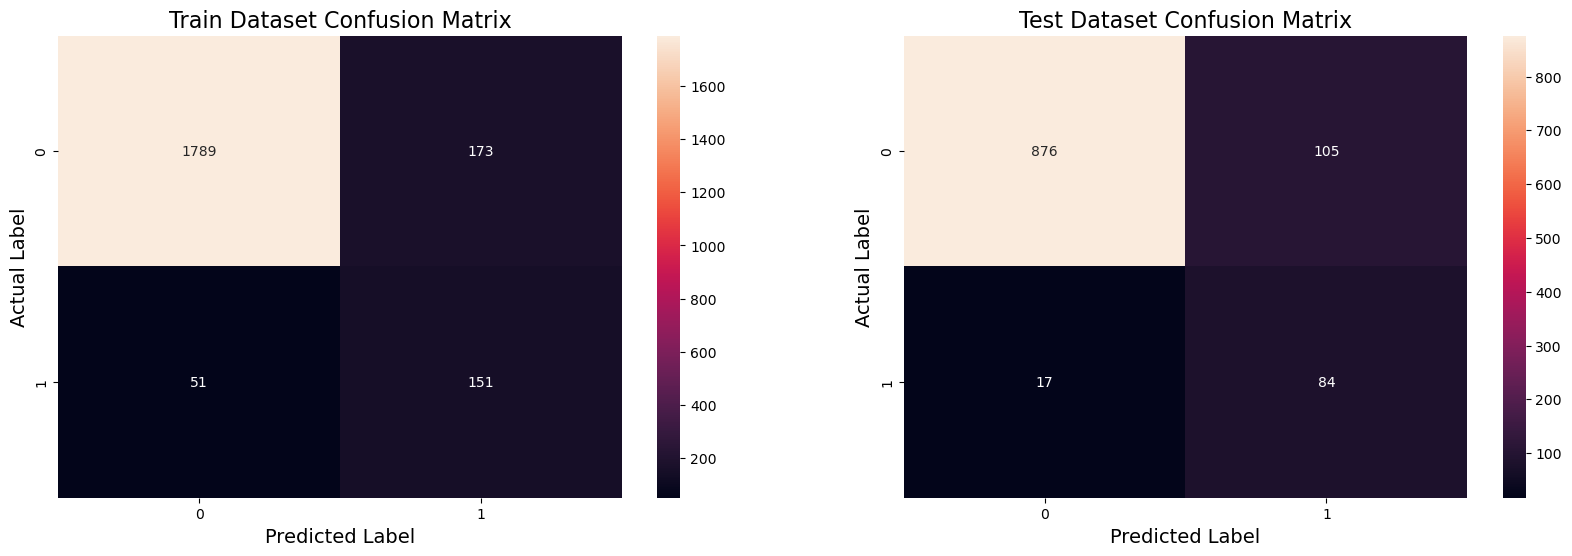

Best Threshold = 0.0758
Model AUC is : 0.8776
Model F1 Score is : 0.5793


In [69]:
# take a list of k values to iterate
list_of_k = [10,20,50,80,100,150]
for k in list_of_k:
    print("="*120)
    print("\t\t\t\t\t\tNumber of base learners = ", k)
    print("="*120)
    # create k datasets
    x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
    
    # train k base learners using these k dataset and get train data from meta model
    x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)
    
    # pass x_val through base learners to generate validation data for meta model
    pred_data_list = []
    for i in range(len(base_model_list)):
        x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
        # print(x_val_.shape)
        pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
        # pred_data = model_list[i].predict(x_val_)
        pred_data_list.append(pred_data)
    x_val_meta_model = np.vstack(pred_data_list).transpose()
    
    # train meta model (logistic regression) using train and validation data from meta model to decide best k
    log_reg = LogisticRegression(C=0.001,penalty="l2")
    log_reg.fit(x_tr_meta_model, y_te_d2)
    y_pred_meta_model = log_reg.predict_proba(x_val_meta_model)[:,1]

    # Validate LogisticRegression model
    test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

    print("Best Threshold = {:.4f}".format(best_t))
    print("Model AUC is : {:.4f}".format(test_auc))
    print("Model F1 Score is : {:.4f}".format(test_f1_score))

All the models are not performing good. Still it is working comperatively better whrn k =50.

#### Meta Model = LogisticRegression

In [70]:
# create 50 sampled dataset
k = 50
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

In [71]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

In [72]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
# find best parameters for Logistic Regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_meta_model, y_te_d2)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", l

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [73]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 100.0, 'penalty': 'l2'}
roc_auc_score : 0.8902843058653362


Train AUC =  0.8898754554354517
Test AUC =  0.9179762012898538


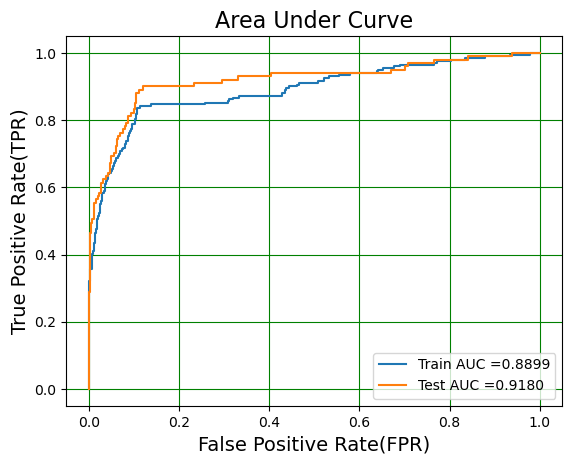

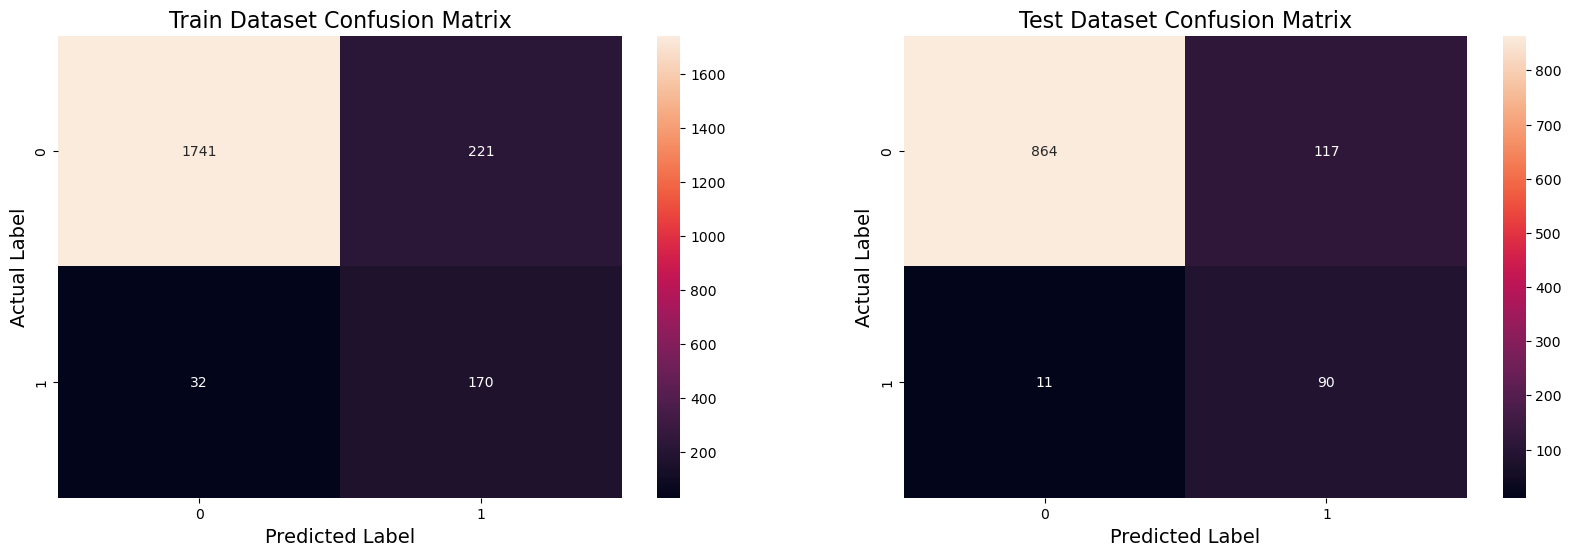

Best Threshold = 0.0490
Model AUC is : 0.9180
Model F1 Score is : 0.5844


In [74]:
# train LR using tuned parameters
log_reg = LogisticRegression(C=10.0, penalty='l2')
log_reg.fit(x_tr_meta_model, y_te_d2)

# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [75]:
combined_table.append_row(["SVM(rbf) + LR", "50", "0.9134", "0.5669"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+
| SVM(Linear) + LR  |         50          | 0.963 |  0.

#### Meta Model - Random Forest

In [76]:
# find best parameters for RF using randomized Search CV
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_meta_model, y_te_d2)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [77]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 5}
roc_auc_score : 0.9343690115219425


In [78]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=10, max_features='auto', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=400,
                       random_state=42)

Train AUC =  0.9737765060909761
Test AUC =  0.9526952695269527


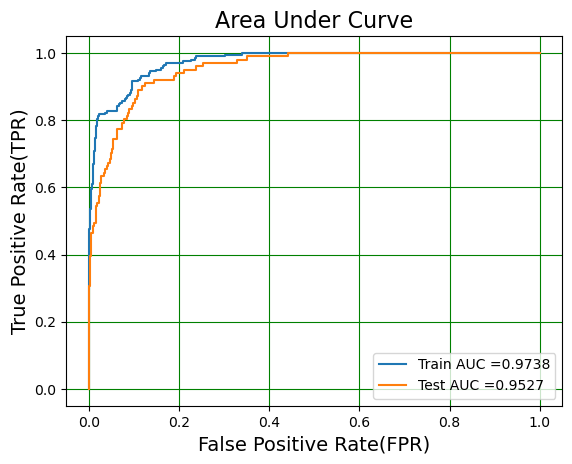

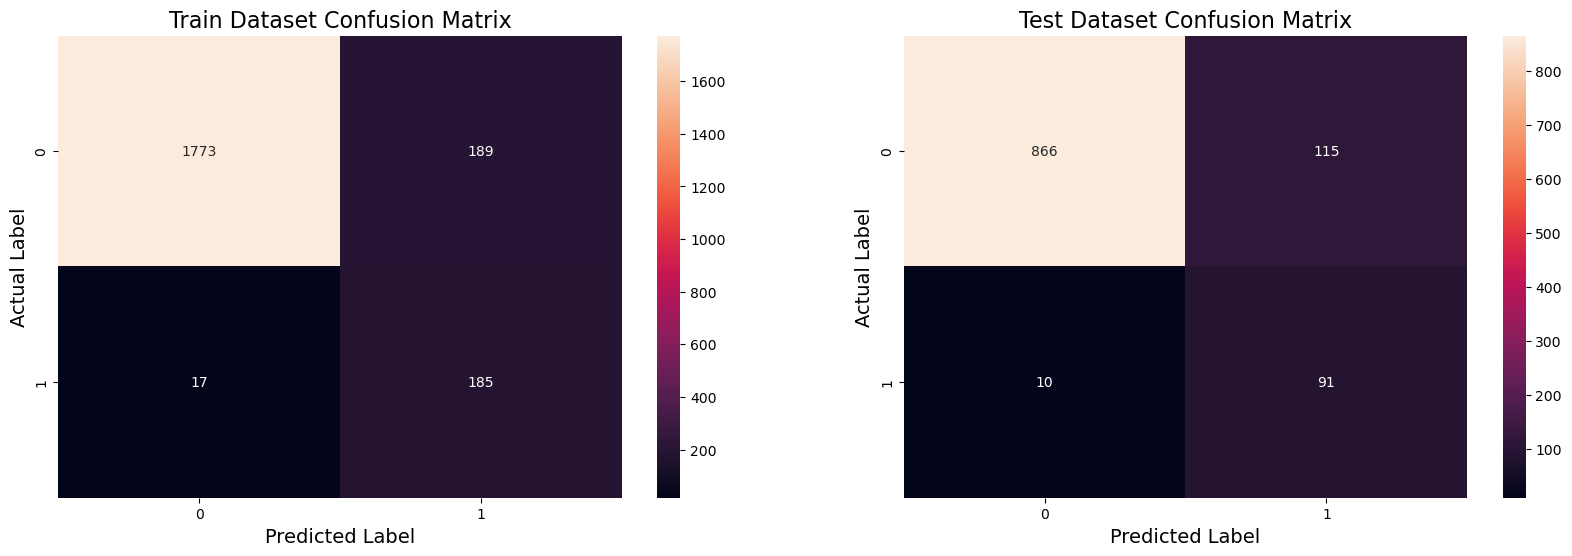

Best Threshold = 0.1218
Model AUC is : 0.9527
Model F1 Score is : 0.5928


In [79]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [80]:
combined_table.append_row(["SVM(rbf) + RF", "50", "0.9456", "0.4831"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+
| SVM(Linear) + LR  |         50          | 0.963 |  0.

## BaseLearner - XGBClassifier

In [81]:
from xgboost import XGBClassifier
from tqdm import tqdm
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    model_list = []
    for i in range(k):
        base_learner = XGBClassifier(learning_rate=0.1, max_delta_step=0, max_depth=10)
        # base_learner_clb = CalibratedClassifierCV(base_learner)
        base_learner = base_learner.fit(x_tr_list[i], y_tr_list[i])
        model_list.append(base_learner)
    
    base_model_prediction_list = []
    for j in range(k):
        #y_pred = model_list[j].predict(x_te_list[j])
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)
    
    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()
    # print(x_tr_from_base_learner.shape)
    
    return x_tr_meta_model, model_list

						Number of base learners =  10
[18:43:48] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:43:49] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:43:50] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:43:51] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' 

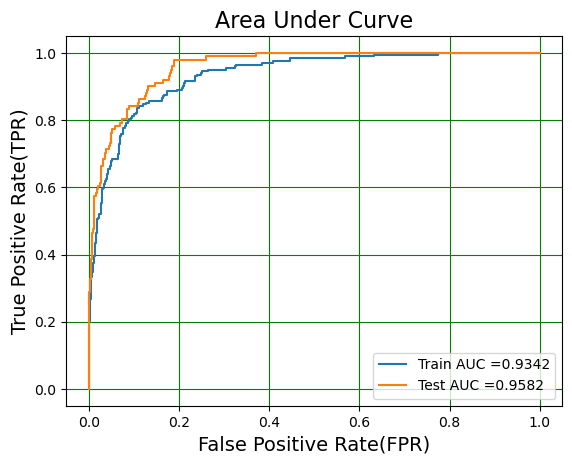

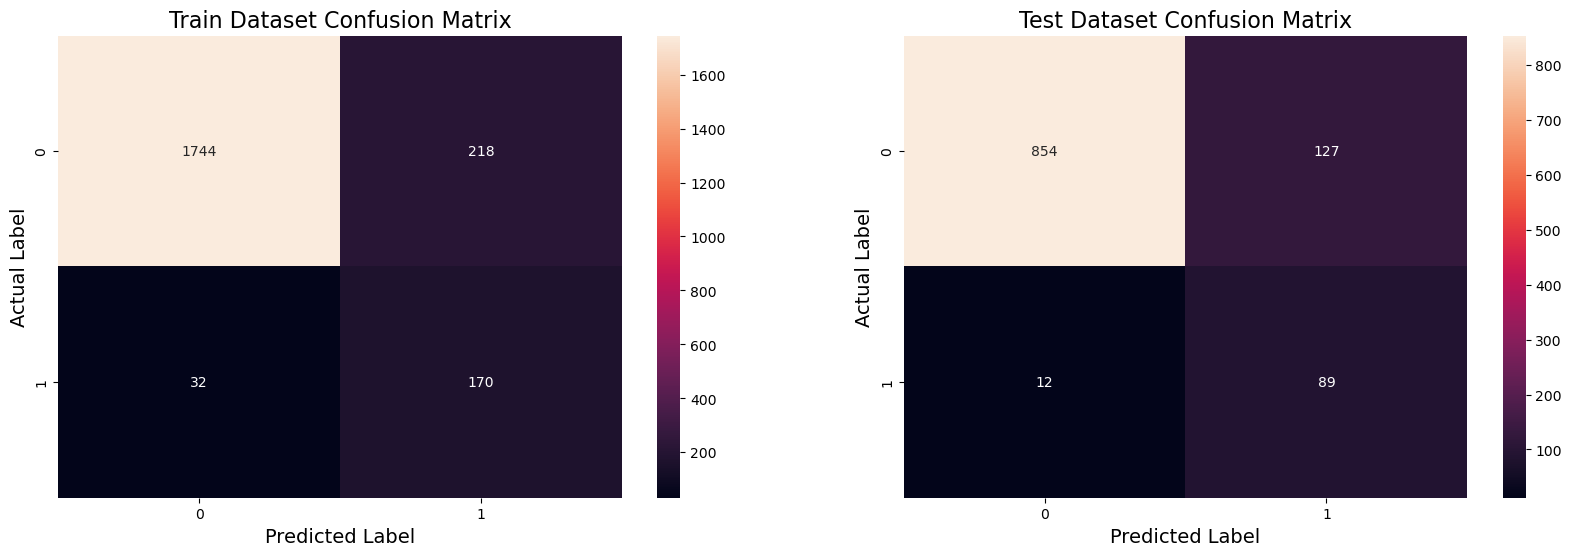

Best Threshold = 0.0921
Model AUC is : 0.9582
Model F1 Score is : 0.5615
						Number of base learners =  20
[18:44:01] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:44:03] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:44:04] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:44:05] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation m

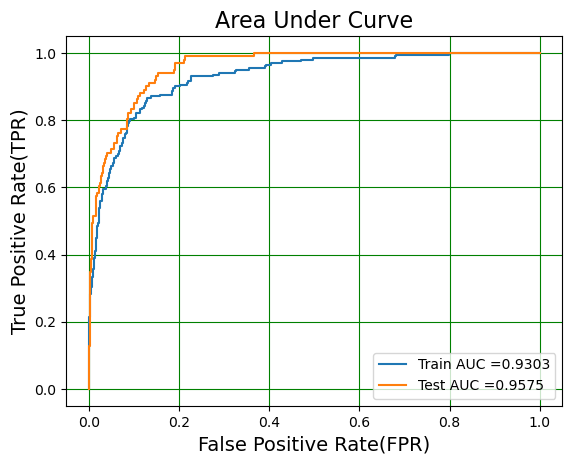

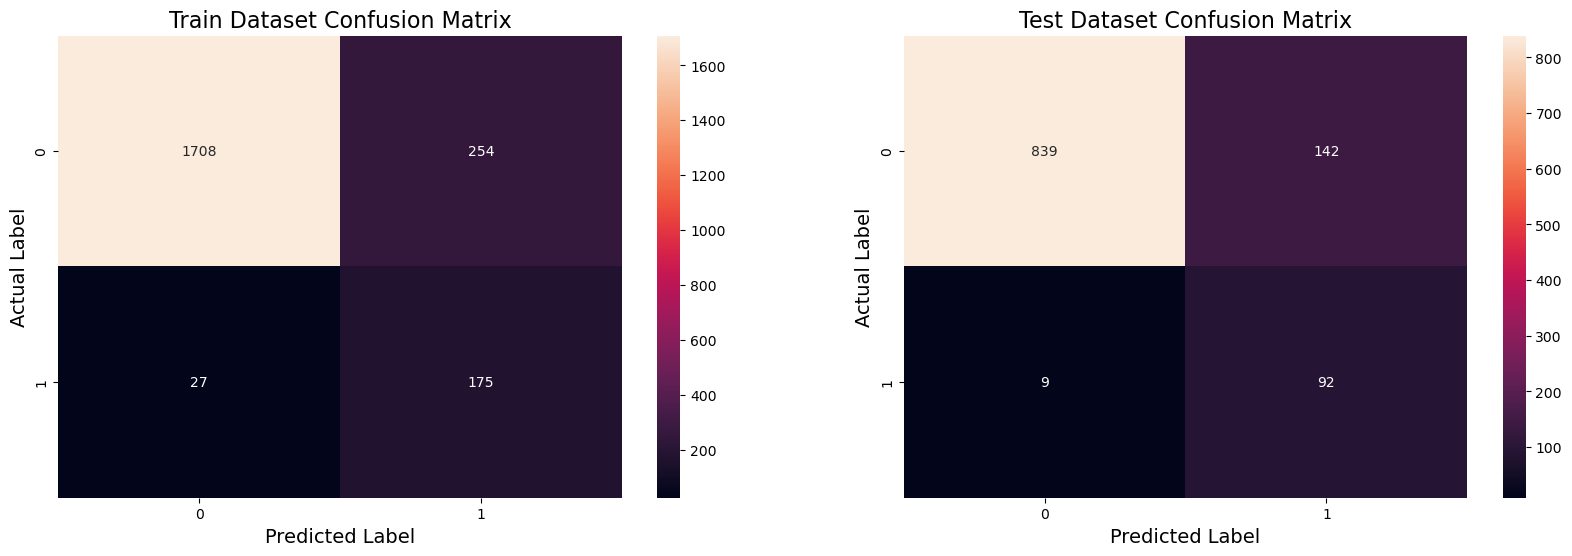

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/xgboost/skle

Best Threshold = 0.0883
Model AUC is : 0.9575
Model F1 Score is : 0.5493
						Number of base learners =  50
[18:44:26] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:44:27] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:44:28] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:44:29] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation m

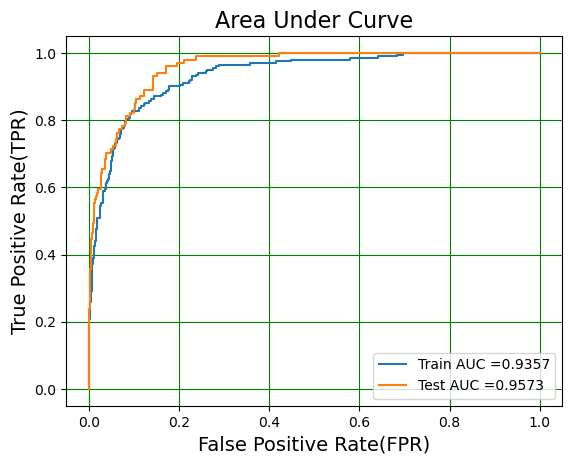

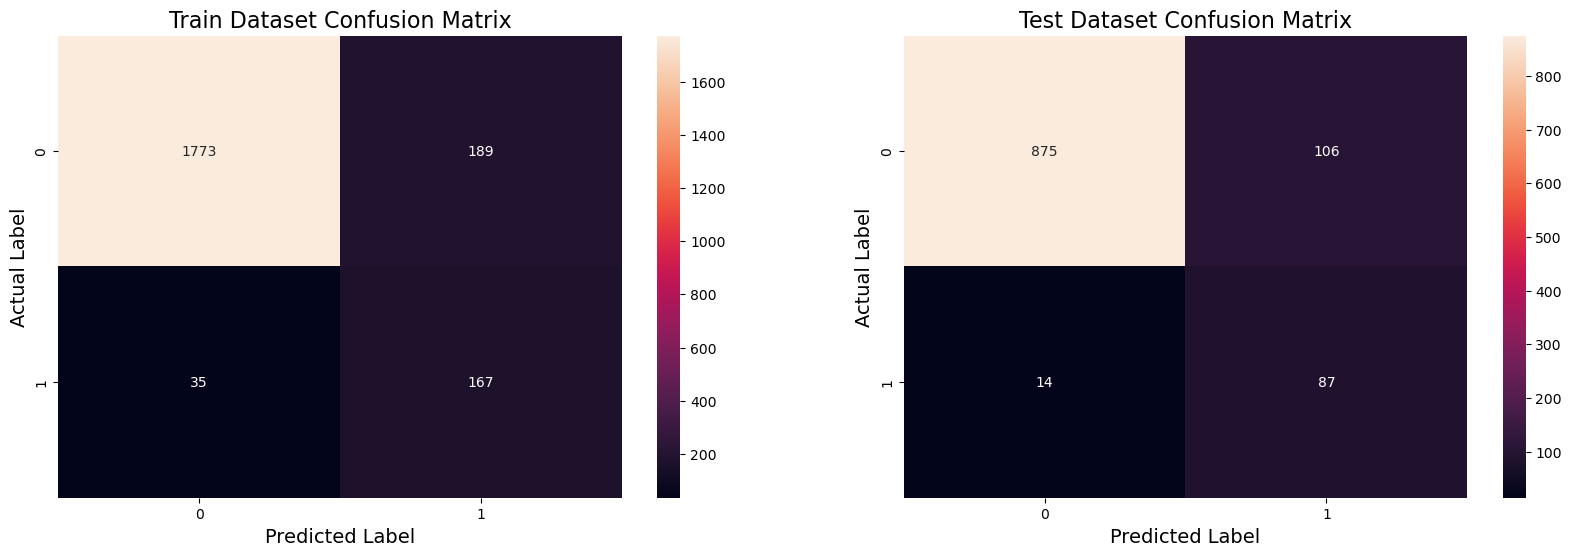

Best Threshold = 0.0870
Model AUC is : 0.9573
Model F1 Score is : 0.5918
						Number of base learners =  80
[18:45:30] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:45:31] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:45:32] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:45:33] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation m

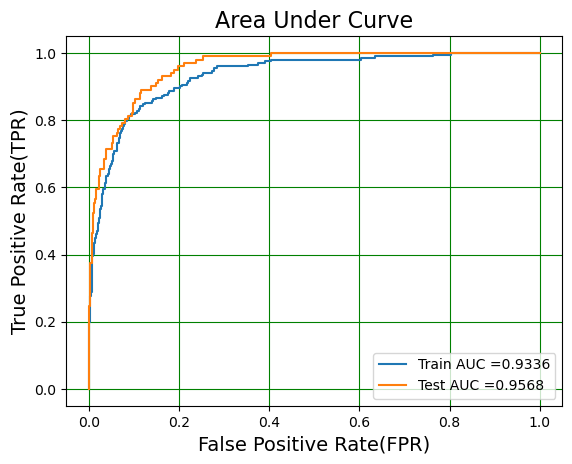

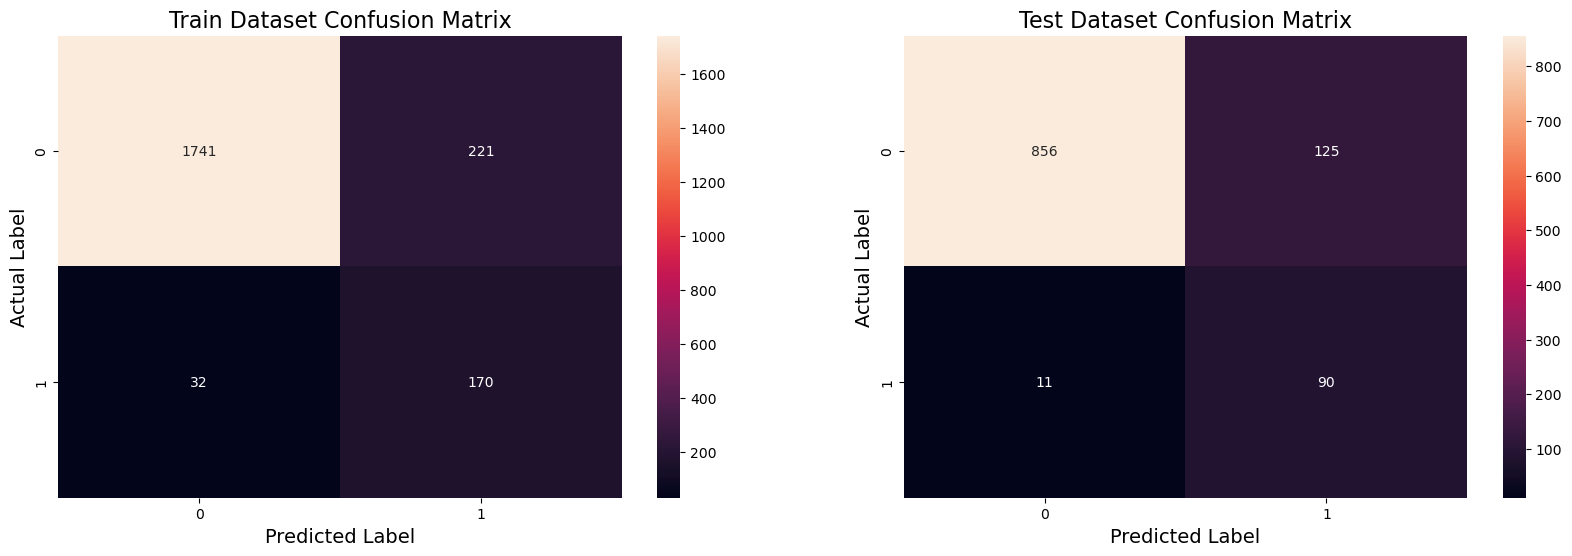

Best Threshold = 0.0776
Model AUC is : 0.9568
Model F1 Score is : 0.5696
						Number of base learners =  100
[18:47:12] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:13] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:15] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:16] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation 

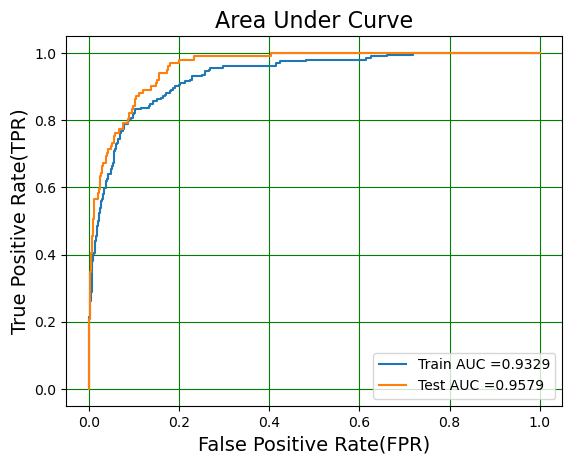

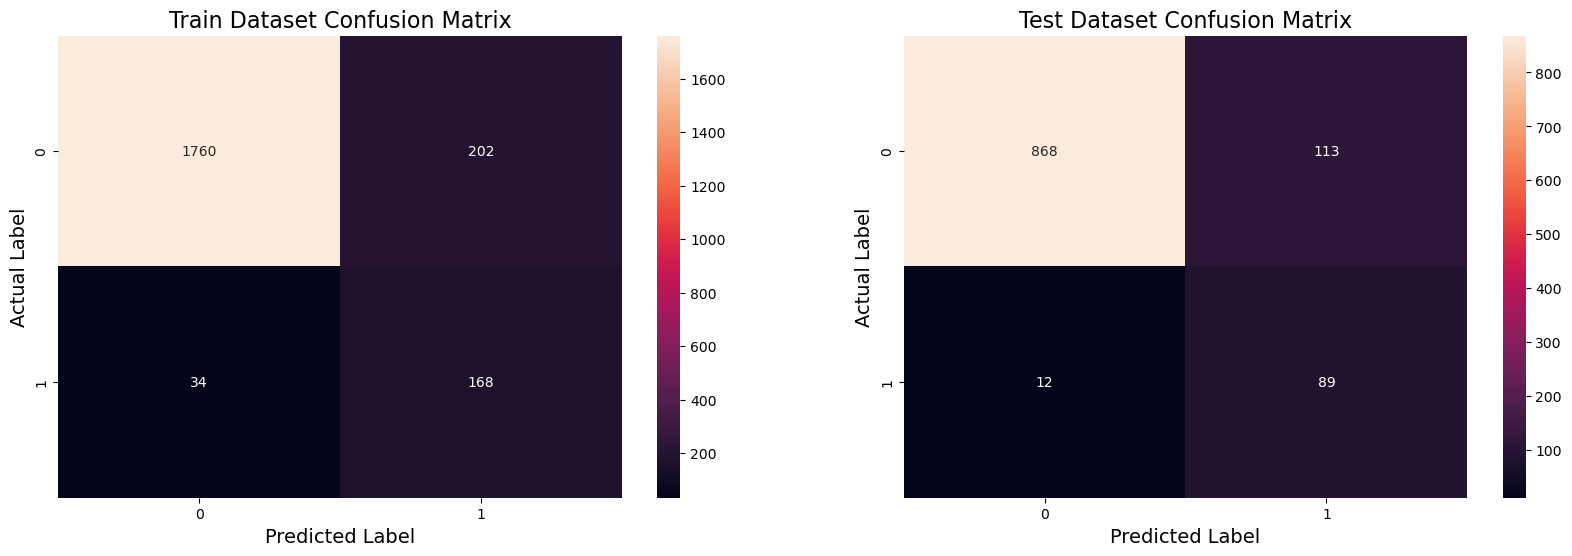

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/xgboost/skle

Best Threshold = 0.0776
Model AUC is : 0.9579
Model F1 Score is : 0.5875
						Number of base learners =  150
[18:49:19] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:20] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:21] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:23] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation 

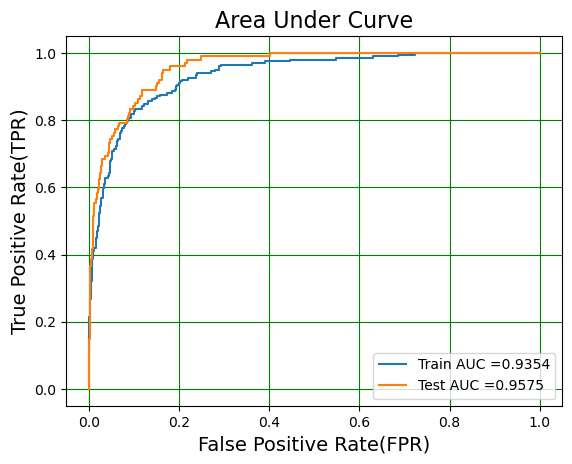

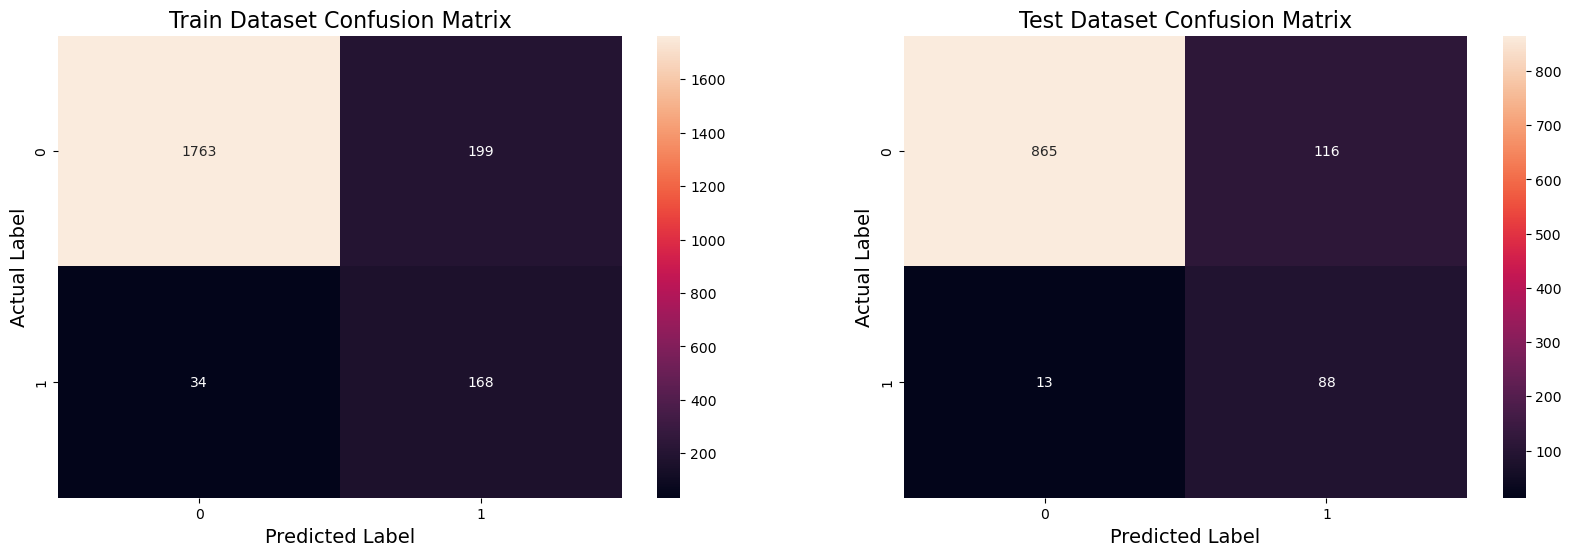

Best Threshold = 0.0731
Model AUC is : 0.9575
Model F1 Score is : 0.5770


In [82]:
# take a list of k values to iterate
list_of_k = [10,20,50,80,100,150]
for k in list_of_k:
    print("="*120)
    print("\t\t\t\t\t\tNumber of base learners = ", k)
    print("="*120)
    # create k datasets
    x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
    
    # train k base learners using these k dataset and get train data from meta model
    x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)
    
    # pass x_val through base learners to generate validation data for meta model
    pred_data_list = []
    for i in range(len(base_model_list)):
        x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
        # print(x_val_.shape)
        pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
        # pred_data = model_list[i].predict(x_val_)
        pred_data_list.append(pred_data)
    x_val_meta_model = np.vstack(pred_data_list).transpose()
    
    # train meta model (logistic regression) using train and validation data from meta model to decide best k
    log_reg = LogisticRegression(C=0.001,penalty="l2")
    log_reg.fit(x_tr_meta_model, y_te_d2)
    y_pred_meta_model = log_reg.predict_proba(x_val_meta_model)[:,1]

    # Validate LogisticRegression model
    test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

    print("Best Threshold = {:.4f}".format(best_t))
    print("Model AUC is : {:.4f}".format(test_auc))
    print("Model F1 Score is : {:.4f}".format(test_f1_score))

Model is working best when k = 80.

#### Meta Model - LogisticRegression

In [83]:
# create 50 sampled dataset
k = 80
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

[18:52:21] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:22] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:24] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:25] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_me

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [84]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

In [85]:
# https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
# find best parameters for Logistic Regression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
logreg_cv.fit(x_tr_meta_model, y_te_d2)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", l

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [86]:
print("best parameters = ",logreg_cv.best_params_)
print("roc_auc_score :",logreg_cv.best_score_)

best parameters =  {'C': 0.001, 'penalty': 'l2'}
roc_auc_score : 0.93667784172876


Train AUC =  0.9370010395534967
Test AUC =  0.9576508109526549


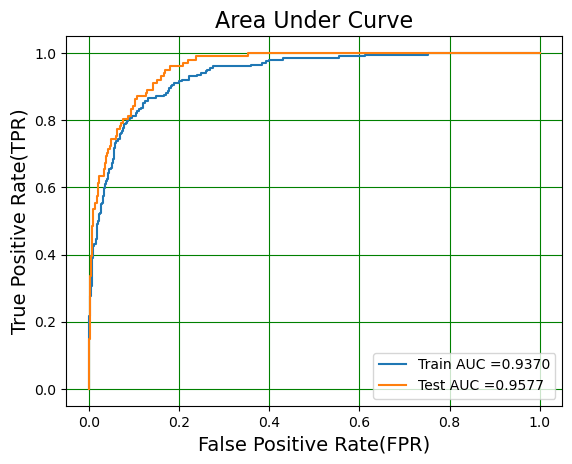

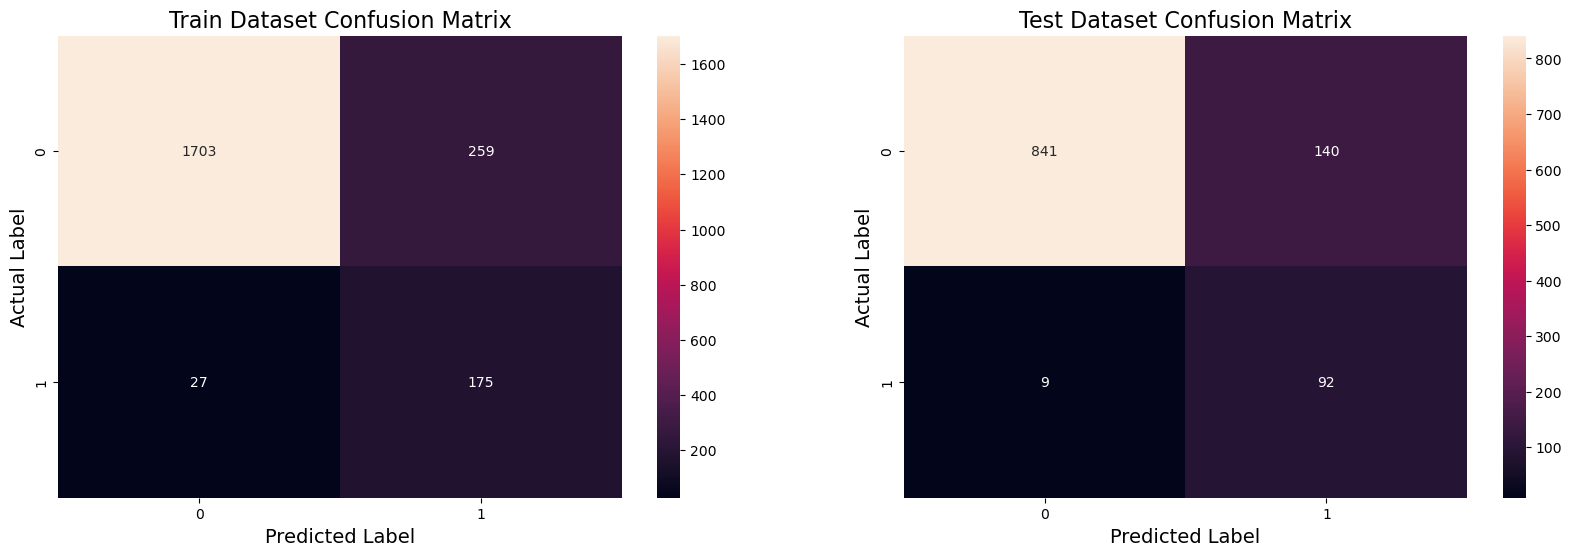

Best Threshold = 0.0502
Model AUC is : 0.9577
Model F1 Score is : 0.5526


In [87]:
# train LR using tuned parameters
log_reg = LogisticRegression(C=0.01, penalty='l2')
log_reg.fit(x_tr_meta_model, y_te_d2)

# Validate LogisticRegression model
test_auc, test_f1_score, best_t = validate_model(log_reg, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [88]:
combined_table.append_row(["XGBClf + LR", "80", "0.9579", "0.5678"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+
| SVM(Linear) + LR  |         50          | 0.963 |  0.

#### Meta Model - Random Forest

In [89]:
# find best parameters for RF using randomized Search CV
params = {'max_depth': [5, 8, 10, 20],
         'max_features': ['auto', 'sqrt'],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400]}

randomforest = RandomForestClassifier(random_state=42)
randomforest_cv = RandomizedSearchCV(randomforest, params, cv= 5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
randomforest_cv.fit(x_tr_meta_model, y_te_d2)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400]},
                   return_train_score=True, scoring='roc_auc')

In [90]:
print("best parameters = ",randomforest_cv.best_params_)
print("roc_auc_score :",randomforest_cv.best_score_)

best parameters =  {'n_estimators': 400, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 5}
roc_auc_score : 0.9391261342090363


In [91]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=5, max_features='sqrt', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_split=5,
                       n_estimators=400, random_state=42)

Train AUC =  0.9807278893026917
Test AUC =  0.9594675063836657


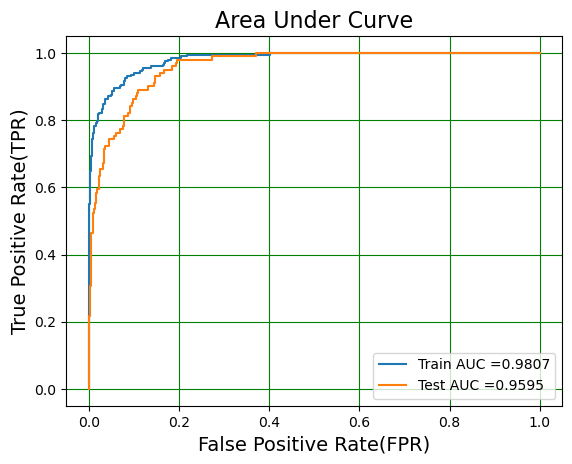

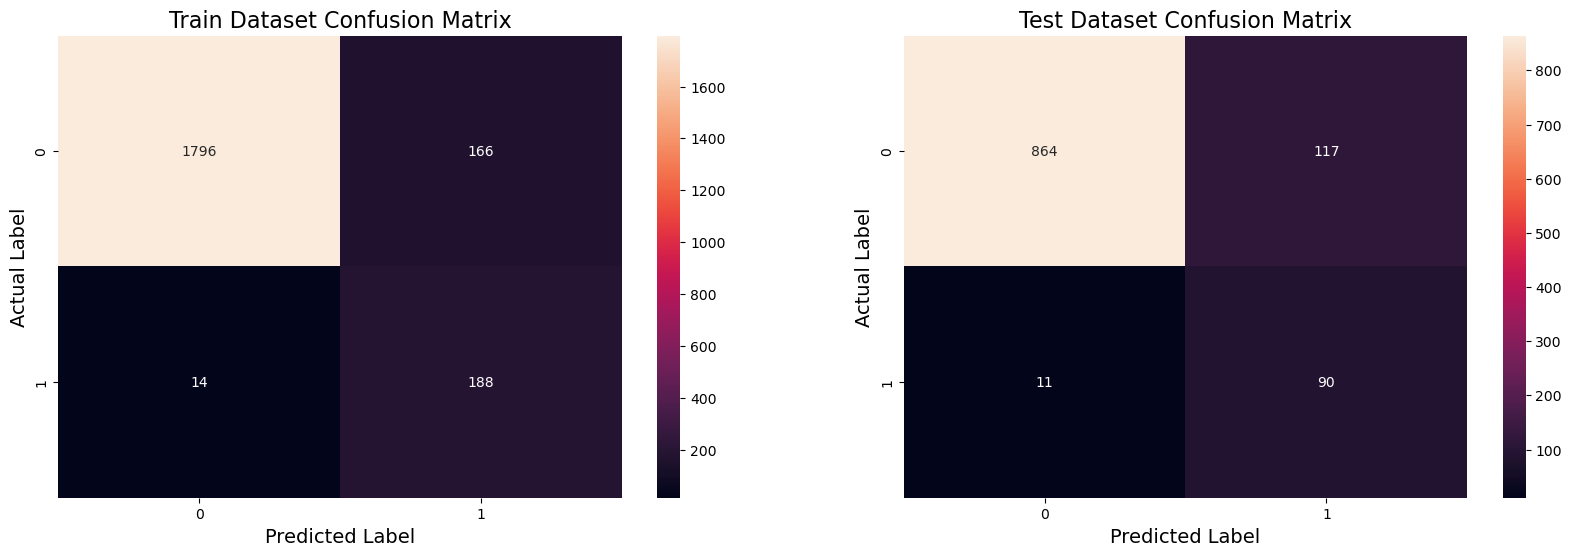

Best Threshold = 0.1278
Model AUC is : 0.9595
Model F1 Score is : 0.5844


In [92]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [93]:
combined_table.append_row(["XGBClf + RF", "80", "0.9594", "0.5663"])
print(combined_table)

+-------------------+---------------------+-------+----------+
| Model Combination | No of base Learners |  AUC  | F1 Score |
+-------------------+---------------------+-------+----------+
|      DT + LR      |         50          | 0.953 |  0.544   |
+-------------------+---------------------+-------+----------+
|      DT + DT      |         50          | 0.914 |   0.5    |
+-------------------+---------------------+-------+----------+
|     DT + SVC      |         50          | 0.942 |  0.503   |
+-------------------+---------------------+-------+----------+
|      DT + RF      |         50          | 0.955 |  0.551   |
+-------------------+---------------------+-------+----------+
|      LR + RF      |         80          | 0.945 |  0.623   |
+-------------------+---------------------+-------+----------+
|     LR + SVC      |         80          | 0.949 |   0.53   |
+-------------------+---------------------+-------+----------+
| SVM(Linear) + LR  |         50          | 0.963 |  0.

#### Meta Model - SVC

In [94]:
# find best parameters for SVC
grid={"C":[0.5, 1.0], "penalty":["l1","l2"]}
svm_clf = svm.LinearSVC()
svm_cv = GridSearchCV(svm_clf, grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
svm_cv.fit(x_tr_meta_model, y_te_d2)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py", line 1185, in _fit_libline

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.5, 1.0], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc')

In [95]:
print("best parameters = ",svm_cv.best_params_)
print("roc_auc_score :",svm_cv.best_score_)

best parameters =  {'C': 0.5, 'penalty': 'l2'}
roc_auc_score : 0.8519582806125616


In [96]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc = LinearSVC(C=0.5, penalty='l2')
clb_clf_svc = CalibratedClassifierCV(linear_svc)
clb_clf_svc.fit(x_tr_meta_model, y_te_d2)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CalibratedClassifierCV(base_estimator=LinearSVC(C=0.5))

Train AUC =  0.9352474238249512
Test AUC =  0.9317931793179319


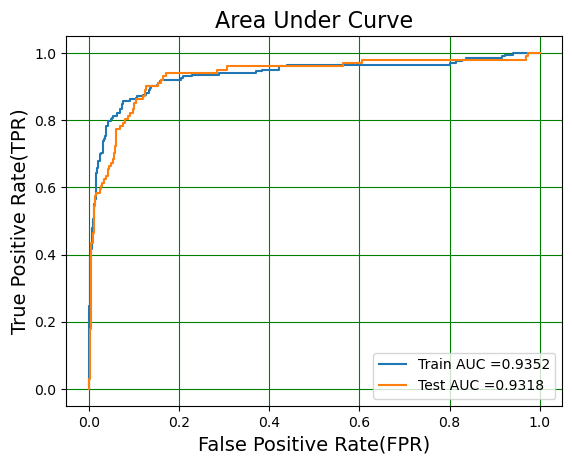

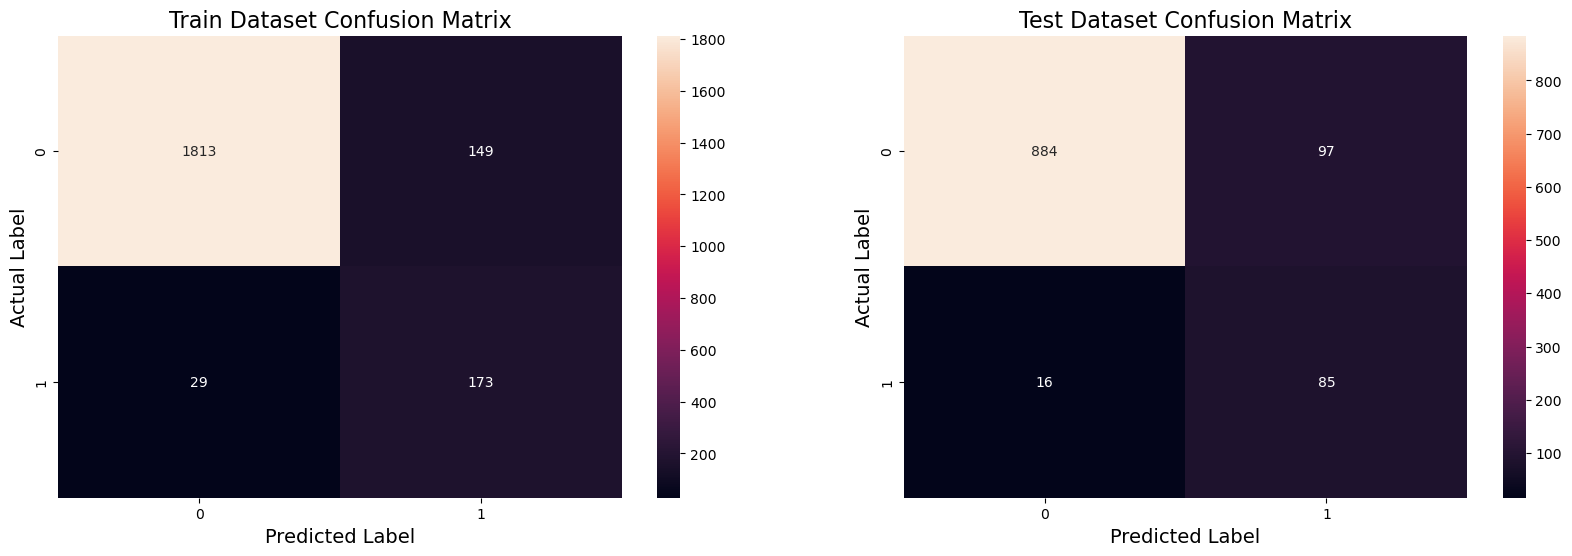

Best Threshold = 0.0770
Model AUC is : 0.9318
Model F1 Score is : 0.6007


In [97]:
# Validate SVC model
test_auc, test_f1_score, best_t = validate_model(clb_clf_svc, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

In [98]:
combined_table.append_row(["XGBClf + LinearSVC", "80", "0.9026", "0.5874"])
print(combined_table)

+--------------------+---------------------+-------+----------+
| Model Combination  | No of base Learners |  AUC  | F1 Score |
+--------------------+---------------------+-------+----------+
|      DT + LR       |         50          | 0.953 |  0.544   |
+--------------------+---------------------+-------+----------+
|      DT + DT       |         50          | 0.914 |   0.5    |
+--------------------+---------------------+-------+----------+
|      DT + SVC      |         50          | 0.942 |  0.503   |
+--------------------+---------------------+-------+----------+
|      DT + RF       |         50          | 0.955 |  0.551   |
+--------------------+---------------------+-------+----------+
|      LR + RF       |         80          | 0.945 |  0.623   |
+--------------------+---------------------+-------+----------+
|      LR + SVC      |         80          | 0.949 |   0.53   |
+--------------------+---------------------+-------+----------+
|  SVM(Linear) + LR  |         50       

## Observation:
Comparing AUC and F1 score for all the combination tried, SVM with linear kernel with 50 base learner and Random forest meta model working the best. <br> AUC = 0.963 and F1 Score =  0.621 

### Train the model which gave the best result

In [99]:
from sklearn import svm
from tqdm import tqdm
def train_k_base_learners(x_tr_list, y_tr_list, x_te_list, k):
    model_list = []
    for i in range(k):
        base_learner = svm.SVC(kernel='linear')
        base_learner_clb = CalibratedClassifierCV(base_learner)
        base_learner_clb = base_learner_clb.fit(x_tr_list[i], y_tr_list[i])
        model_list.append(base_learner_clb)
    
    base_model_prediction_list = []
    for j in range(k):
        #y_pred = model_list[j].predict(x_te_list[j])
        y_pred = model_list[j].predict_proba(x_te_list[j])[:,1]
        base_model_prediction_list.append(y_pred)
    
    x_tr_meta_model = np.vstack(base_model_prediction_list).transpose()
    # print(x_tr_from_base_learner.shape)
    
    return x_tr_meta_model, model_list

In [100]:
# create 50 sampled dataset
k = 50
x_tr_list_d1, y_tr_list_d1, x_te_list_d2, y_te_d2, sampled_col_indices_list = create_k_dataset(x_d1, x_d2, y_d1, y_d2, k)
# train base learners with each samples dataset
x_tr_meta_model, base_model_list = train_k_base_learners(x_tr_list_d1, y_tr_list_d1, x_te_list_d2, k)

In [101]:
# pass x_val through base learners to generate validation data for meta model
pred_data_list = []
for i in range(len(base_model_list)):
    x_val_base_learner = x_val[:, sampled_col_indices_list[i]]
    # print(x_val_.shape)
    pred_data = base_model_list[i].predict_proba(x_val_base_learner)[:,1]
    # pred_data = model_list[i].predict(x_val_)
    pred_data_list.append(pred_data)
x_val_meta_model = np.vstack(pred_data_list).transpose()

In [102]:
random_forest = RandomForestClassifier(n_estimators=400, min_samples_split=10, max_features='auto', max_depth=5, random_state=42)
random_forest.fit(x_tr_meta_model, y_te_d2)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=400,
                       random_state=42)

Train AUC =  0.9806799487288178
Test AUC =  0.9631917320172385


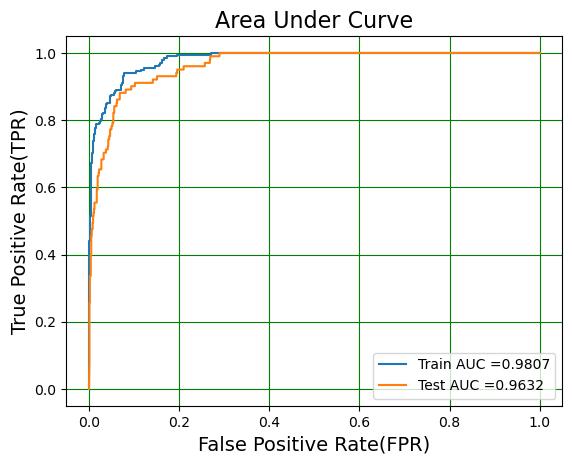

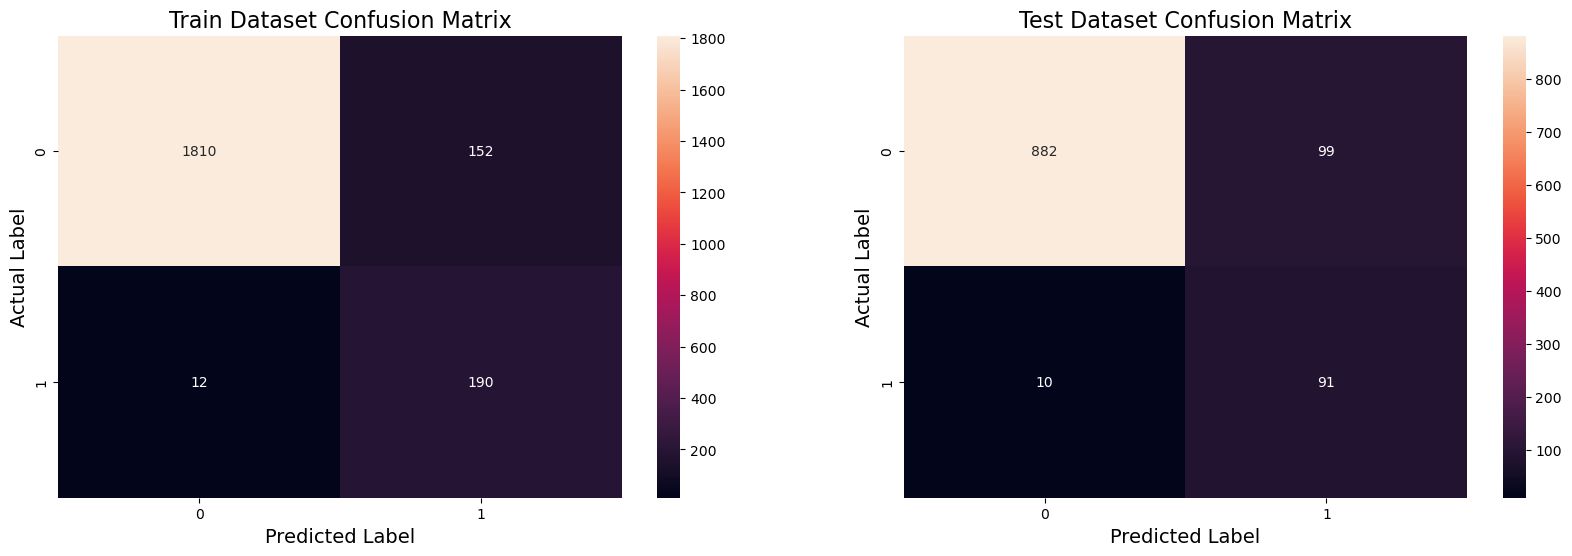

Best Threshold = 0.1777
Model AUC is : 0.9632
Model F1 Score is : 0.6254


In [103]:
# Validate RF model
test_auc, test_f1_score, best_t = validate_model(random_forest, x_tr_meta_model, x_val_meta_model, y_te_d2, y_val)

print("Best Threshold = {:.4f}".format(best_t))
print("Model AUC is : {:.4f}".format(test_auc))
print("Model F1 Score is : {:.4f}".format(test_f1_score))

# Conclusion:
Model performance is increased in terms of both AUC and F1 score using ensemble model (Linear SVM + RF) than using a single first cut model.

#### Add the predicted labels to the dataframe containing original label

In [104]:
y_val_pred = pred_prob(random_forest, x_val_meta_model)
y_val_prediction = predict_with_best_t(y_val_pred, best_t)
x_validation_provider_labels['Predicted_Label'] = y_val_prediction
x_validation_provider_labels = x_validation_provider_labels.reset_index(drop=True)

<ipython-input-104-858bcded9130>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_validation_provider_labels['Predicted_Label'] = y_val_prediction


In [105]:
x_validation_provider_labels.head(10)

Provider  PotentialFraud  Predicted_Label
0  PRV52573               0                0
1  PRV52731               0                0
2  PRV53323               0                0
3  PRV53166               0                0
4  PRV56177               0                0
5  PRV52878               0                0
6  PRV54477               0                0
7  PRV51176               0                0
8  PRV56819               0                1
9  PRV52599               0                0

In [106]:
x_validation_provider_labels.tail(10)

Provider  PotentialFraud  Predicted_Label
1072  PRV53752               0                0
1073  PRV53539               0                0
1074  PRV52417               0                0
1075  PRV56528               0                0
1076  PRV52340               1                1
1077  PRV53129               0                0
1078  PRV51209               0                0
1079  PRV55446               0                0
1080  PRV56346               0                0
1081  PRV56080               0                0

In [107]:
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
print('Execution time in minutes: ' + str(executionTime/60))

Execution time in seconds: 1826.4109630584717
Execution time in minutes: 30.440182717641196
